# Importing packages

In [1]:
import warnings
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import scipy.io as sio
from datetime import datetime, timedelta, date
import os
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matlab.engine

now = datetime.now()

# Functions

In [2]:
def DpH_str_calc(DpH):
    if DpH == 1:
        DpH_str = '1H'
    elif DpH == 2:
        DpH_str = '30min'
    elif DpH == 4:
        DpH_str = '15min'
    else:
        warnings.warn('Invalid DpH')
    return DpH_str

def sym_mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    sMAPE = 2 * (np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))).mean()
    return sMAPE

def highlight_min(s):
    '''
    highlight the minimum in a Series yellow.
    '''
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]

# Hyper parameters

In [3]:
### Smart meters dates:
SM_date_1 = "2020-01-01 00:00"
SM_date_2 = "2020-04-04 23:45"
### DpH: resample period
DpH = 1
DpH_str = DpH_str_calc(DpH)

### TEST_DAY: Number of test days (last "TEST_DAY" days are considered as testing values)
TEST_DAY = 7

### ARIMA Model parameters
p_order = 1
d_order = 1
q_order = 1
PS_order = 1
DS_order = 1
QS_order = 1

### "learn" or "load" different models
ARIMA_Model =  'load'
ARIMA_Model_exg =  'load'
RF_Model = 'load'
RF_Model_exg = 'load'
RF_Model_exg_complet = 'load'

### Data addresses
SM_address = './Data/Smart meters/DonneesTri 2020.07.03.mat'
GE_address = '/Data/GridEye'

### Outputs addresses
lastload = '082720_103547'
pickle_address_load = "./Outputs/Pickle/Model" + lastload + ".pickle"
csv_address_load = "./Outputs/csv/Model" + lastload + ".csv"
pickle_address_save = "./Outputs/Pickle/Model" + now.strftime("%m%d%y_%H%M%S") + ".pickle"
csv_address_save = "./Outputs/csv/Model" + now.strftime("%m%d%y_%H%M%S") + ".csv"
Fig_address_save = './Outputs/Figs/' 
SE_address_save = "./Outputs/mat/GDS_ERR_" + now.strftime("%m%d%y_%H%M%S")
grid_address = "./Outputs/mat/GDS_" + now.strftime("%m%d%y_%H%M%S")

### Selecting feeders
Valid_GEs_FC = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'] # ['1', '5']
Valid_GEs_SE = ['1', '5', '9'] # ['1', '5']

### State Estimation
GE_in_SE = 0

# Loading smart-meters (SMs) data

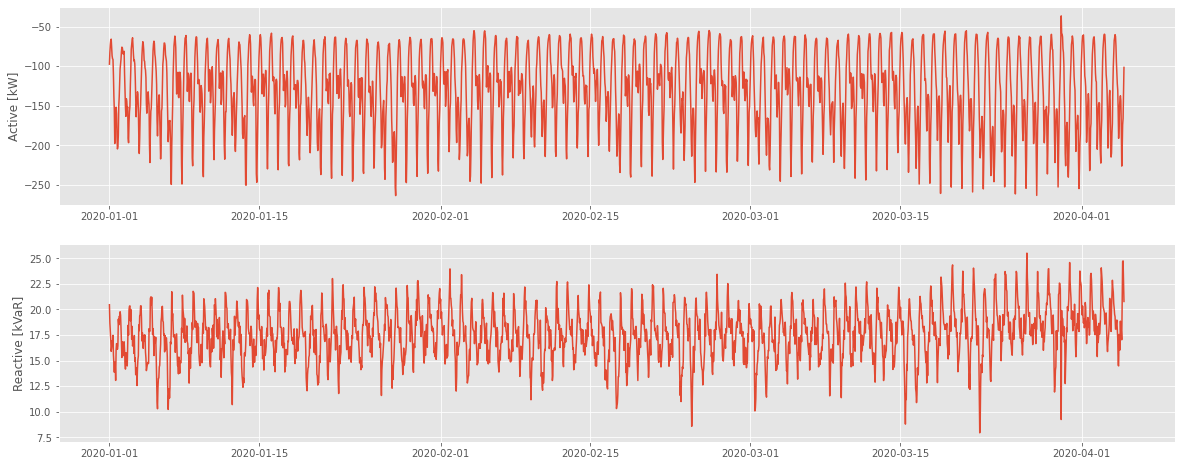

In [4]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

Input = sio.loadmat(SM_address)
Loads_EPP = Input['courbesChargesTot']['mesuresEPP']
Loads_EPC = Input['courbesChargesTot']['mesuresEPC']
Loads_EQL = Input['courbesChargesTot']['mesuresEQL']
Loads_EQC = Input['courbesChargesTot']['mesuresEQC']

Nbus = len(Loads_EPP[0][0])
Nt = len(Loads_EPP[0][0][0])
Nd = int(Nt / (24 * 4))

Dates = pd.date_range(start=SM_date_1, end=SM_date_2, freq='15min')
DF_P = pd.DataFrame()
DF_Q = pd.DataFrame()
DF_P['Time'] = Dates
DF_Q['Time'] = Dates
for i in range(Nbus):
    DF_P[str(i+1)] = Loads_EPP[0][0][i] - Loads_EPC[0][0][i] 
    DF_Q[str(i+1)] = Loads_EQC[0][0][i] - Loads_EQL[0][0][i]

DF_P = DF_P.sort_values('Time')
DF_P = DF_P.set_index('Time')
DF_P = DF_P.resample(DpH_str).sum()

DF_Q = DF_Q.sort_values('Time')
DF_Q = DF_Q.set_index('Time')
DF_Q = DF_Q.resample(DpH_str).sum()

DF_P['tot'] = DF_P.sum(axis=1)
DF_Q['tot'] = DF_Q.sum(axis=1)

DF_P = DF_P.fillna(value=0)
DF_Q = DF_Q.fillna(value=0)

plt.rcParams['figure.figsize']=(20,8)
plt.style.use('ggplot')

plt.figure()
ax = plt.subplot(2, 1, 1)
plt.plot(DF_P['tot'])
ax.set_ylabel('Active [kW]')
ax = plt.subplot(2, 1, 2)
plt.plot(DF_Q['tot'])
ax.set_ylabel('Reactive [kVaR]');

# Loading grid-eyes (GEs) data

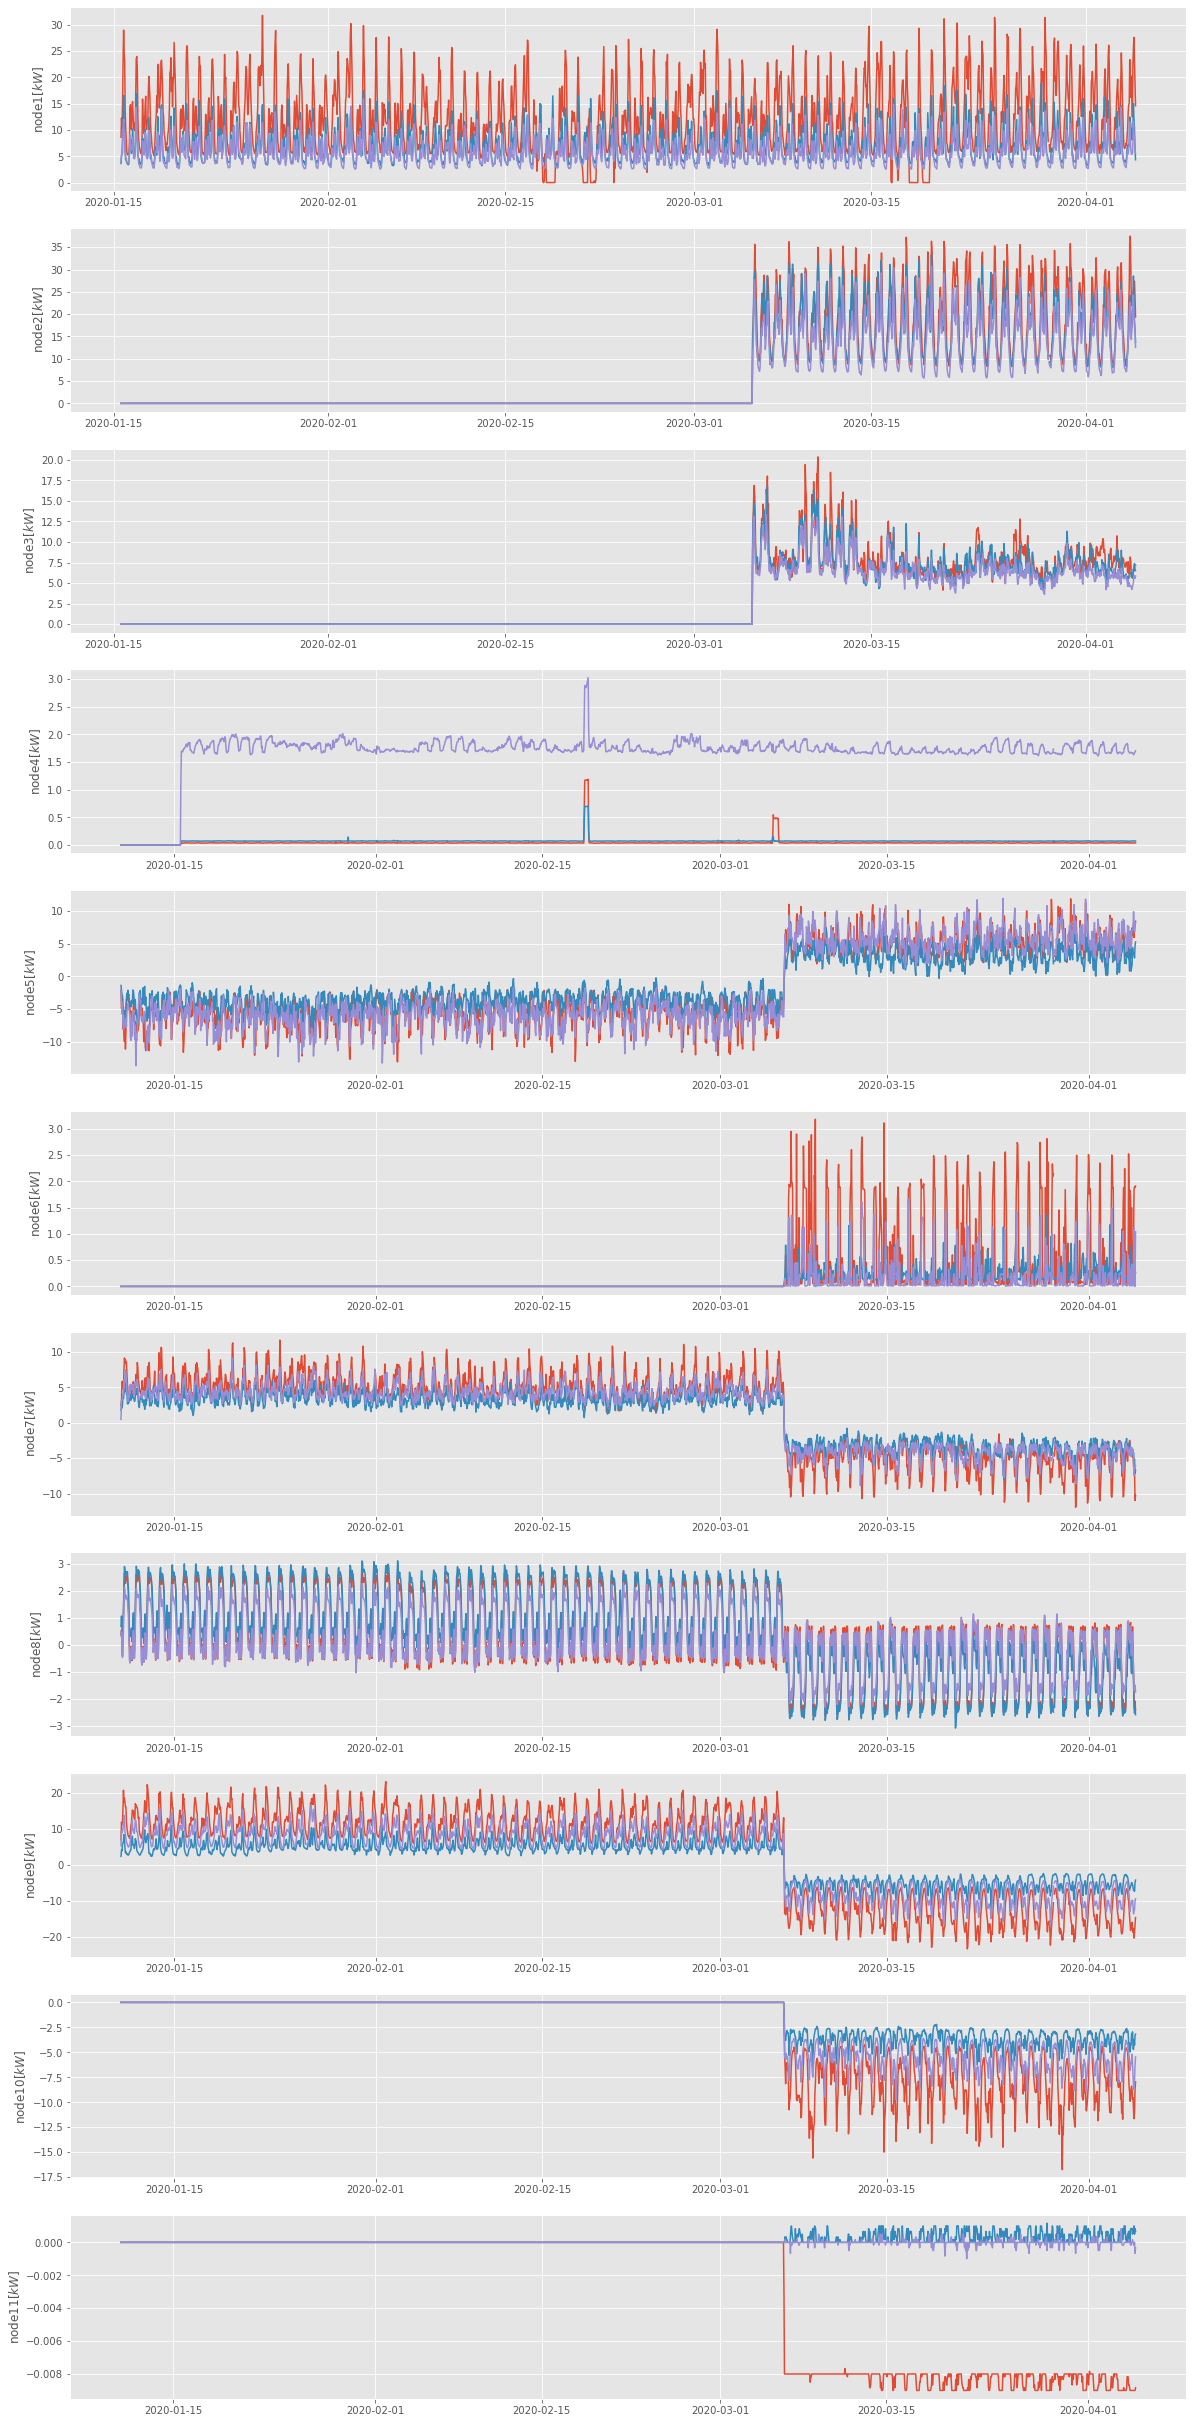

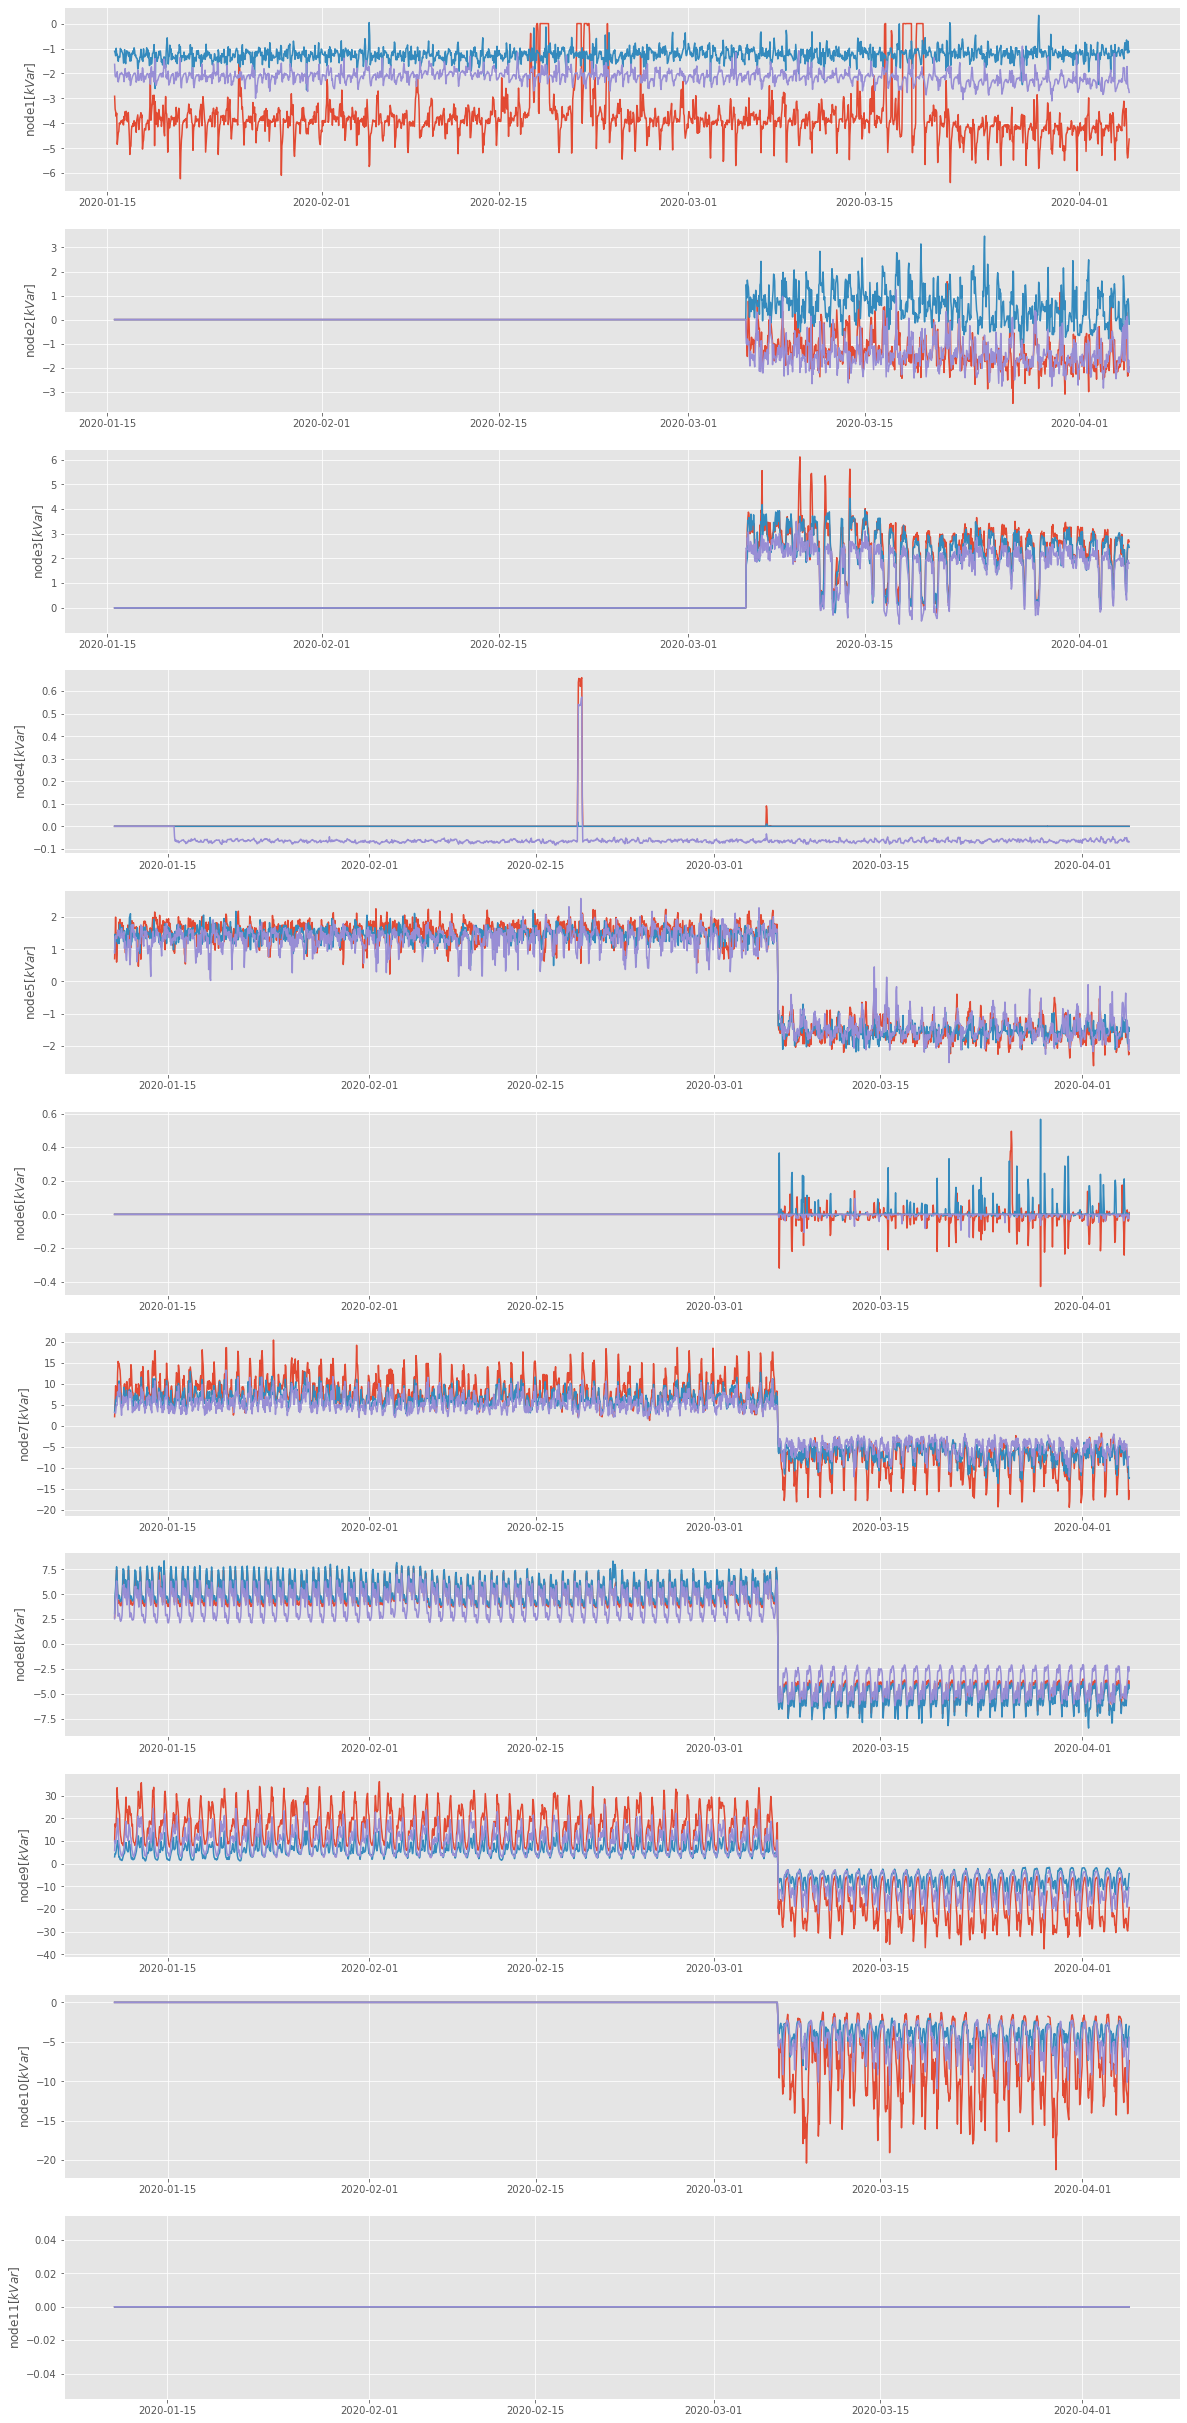

In [5]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

cwd = os.getcwd()
main_folder = cwd + GE_address
listOfFiles = os.listdir(main_folder)
listOfFiles = pd.DataFrame(listOfFiles)
pattern = "*.csv"  
DataGE = []

NGE = 11
for i in range(NGE):
    file_name = listOfFiles[listOfFiles[0].str.contains("00" + np.str(i + 1) + "_")]
    if not file_name.empty:
        file_name = file_name.iat[0, 0]
        csv_file = main_folder + "/" +  file_name
        DataGE.append(pd.read_csv(open(csv_file, 'rb'), delimiter=';'))
        DataGE[i]['Time'] = pd.to_datetime(DataGE[i]['Data time'])
        DataGE[i] = DataGE[i].set_index('Time')
        DataGE[i] = DataGE[i].resample(DpH_str).mean()
    else:
        DataGE.append(pd.DataFrame())


plt.rcParams['figure.figsize']=(20, 4 * NGE)
plt.style.use('ggplot')

plt.figure()
for n in range(NGE):
    ax = plt.subplot(NGE, 1, n + 1)
    plt.plot(DataGE[n]['P L1 [kW]'])
    plt.plot(DataGE[n]['P L2 [kW]'])
    plt.plot(DataGE[n]['P L3 [kW]'])
    ax.set_ylabel('node' + str(n + 1) + '[$kW$]')        

plt.rcParams['figure.figsize']=(20, 4 * NGE)
plt.style.use('ggplot')

plt.figure()
for n in range(NGE):
    ax = plt.subplot(NGE, 1, n + 1)
    plt.plot(DataGE[n]['Q L1 [kVar]'])
    plt.plot(DataGE[n]['Q L2 [kVar]'])
    plt.plot(DataGE[n]['Q L3 [kVar]'])
    ax.set_ylabel('node' + str(n + 1) + '[$kVar$]')  

# Modifying and Cleaning the data of GE (specific for this dataset)

2020-01-16 00:00:00
2020-04-04 23:00:00


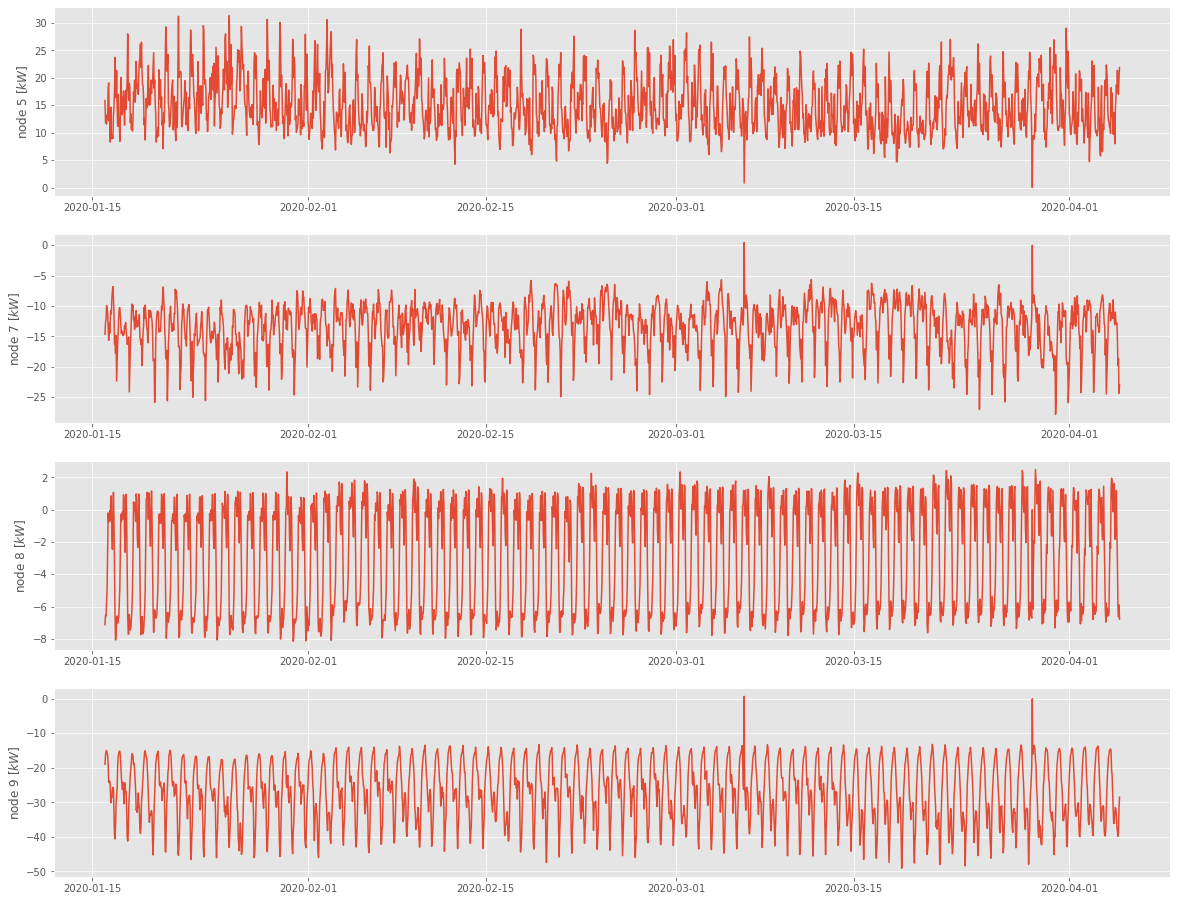

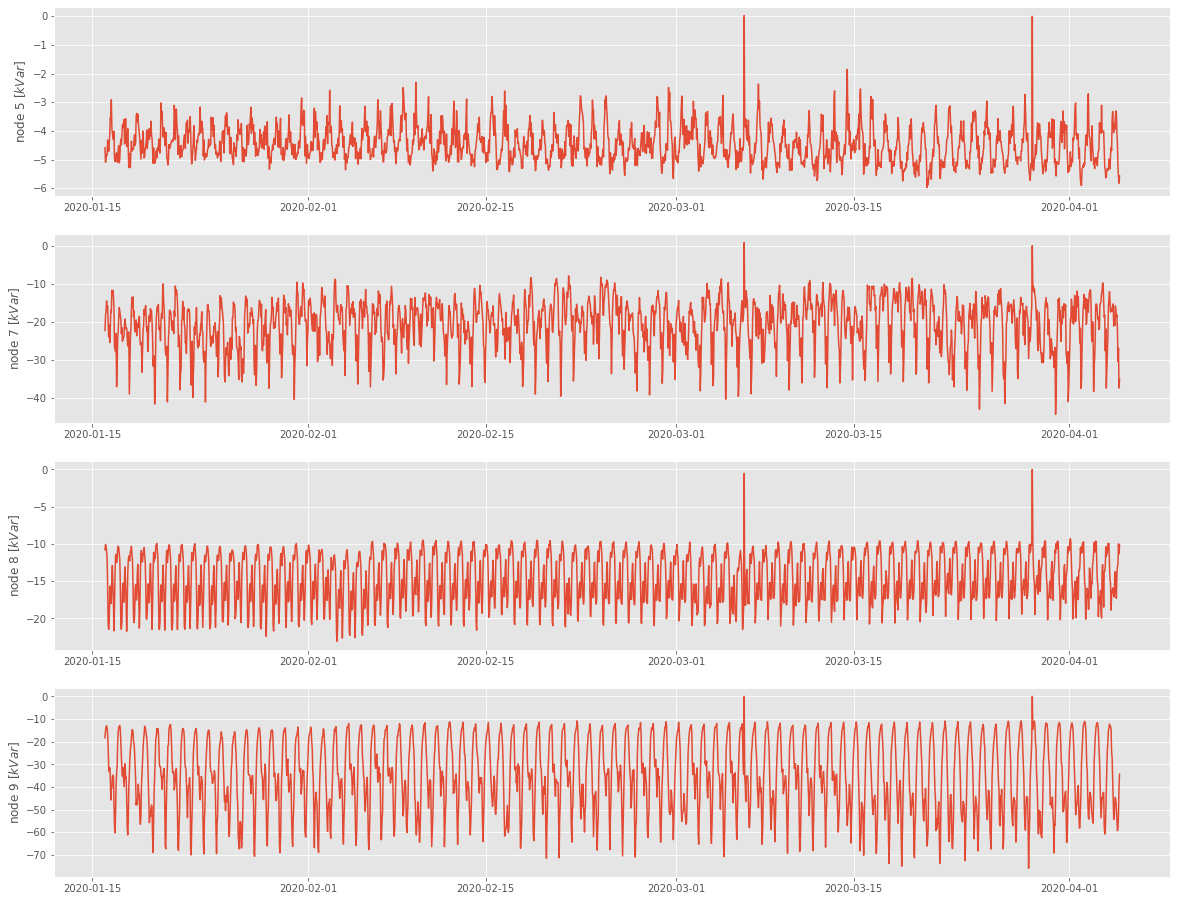

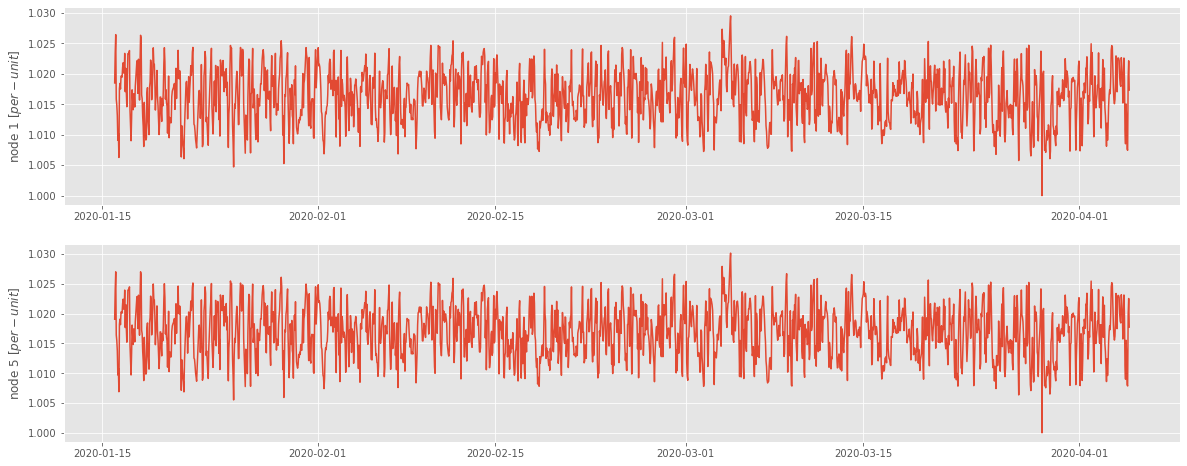

In [6]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

Dmin = DF_P.index.min()
Dmax = DF_P.index.max()
for i in range(NGE):
    Dmin = max([DataGE[i].index.min(), Dmin])
    Dmax = min([DataGE[i].index.max(), Dmax])
Dmin = Dmin + timedelta(days=1)
Dmin = Dmin.strftime('%Y-%m-%d 00:00:00')


DF_P = DF_P[Dmin:Dmax]
DF_Q = DF_Q[Dmin:Dmax]

Dates = pd.date_range(start=Dmin,end=Dmax, freq=DpH_str)
DF_GE_P = pd.DataFrame()
DF_GE_Q = pd.DataFrame()
DF_GE_V = pd.DataFrame()
DF_GE_P['Time'] = Dates
DF_GE_Q['Time'] = Dates
DF_GE_V['Time'] = Dates
for i in range(NGE):
    temp = pd.DataFrame()
    temp['P'] = DataGE[i]['P L1 [kW]'] + DataGE[i]['P L2 [kW]'] + DataGE[i]['P L3 [kW]']
    temp['Q'] = DataGE[i]['Q L1 [kVar]'] + DataGE[i]['Q L2 [kVar]'] + DataGE[i]['Q L3 [kVar]']
    temp['V'] = (DataGE[i]['Voltage L1 avg [V]'] + DataGE[i]['Voltage L2 avg [V]'] + DataGE[i]['Voltage L3 avg [V]']) / (np.sqrt(3) * 400)
    DF_GE_P[str(i+1)] = np.array(temp['P'][Dmin:Dmax])
    DF_GE_Q[str(i+1)] = np.array(temp['Q'][Dmin:Dmax])
    DF_GE_V[str(i+1)] = np.array(temp['V'][Dmin:Dmax])

DF_GE_P = DF_GE_P.sort_values('Time')
DF_GE_P = DF_GE_P.set_index('Time')

DF_GE_Q = DF_GE_Q.sort_values('Time')
DF_GE_Q = DF_GE_Q.set_index('Time')

DF_GE_V = DF_GE_V.sort_values('Time')
DF_GE_V = DF_GE_V.set_index('Time')

DF_GE_P = DF_GE_P.fillna(value=0)
DF_GE_Q = DF_GE_Q.fillna(value=0)
DF_GE_V = DF_GE_V.fillna(value=1)

DF_GE_P['5'][Dmin:"2020-03-06 9:00:00"] = - DF_GE_P['5'][Dmin:"2020-03-06 9:00:00"]
DF_GE_P['7'][Dmin:"2020-03-06 9:00:00"] = - DF_GE_P['7'][Dmin:"2020-03-06 9:00:00"]
DF_GE_P['8'][Dmin:"2020-03-06 9:00:00"] = - DF_GE_P['8'][Dmin:"2020-03-06 9:00:00"]
DF_GE_P['9'][Dmin:"2020-03-06 9:00:00"] = - DF_GE_P['9'][Dmin:"2020-03-06 9:00:00"]

DF_GE_Q['5'][Dmin:"2020-03-06 9:00:00"] = - DF_GE_Q['5'][Dmin:"2020-03-06 9:00:00"]
DF_GE_Q['7'][Dmin:"2020-03-06 9:00:00"] = - DF_GE_Q['7'][Dmin:"2020-03-06 9:00:00"]
DF_GE_Q['8'][Dmin:"2020-03-06 9:00:00"] = - DF_GE_Q['8'][Dmin:"2020-03-06 9:00:00"]
DF_GE_Q['9'][Dmin:"2020-03-06 9:00:00"] = - DF_GE_Q['9'][Dmin:"2020-03-06 9:00:00"]

DF_GE_P['tot'] = DF_GE_P.sum(axis=1)
DF_GE_Q['tot'] = DF_GE_Q.sum(axis=1)

GD1 = ['1']
GD5 = ['5']
DF_GE_P['tot_F1+F5'] = DF_GE_P[GD1+GD5].sum(axis=1)
DF_GE_Q['tot_F1+F5'] = DF_GE_Q[GD1+GD5].sum(axis=1)


Nt = len(np.array(DF_GE_P['tot']))
Nd = int(Nt / (24 * DpH))


plt.rcParams['figure.figsize']=(20, 4 * 4)
plt.style.use('ggplot')

plt.figure()
ax = plt.subplot(4, 1, 1)
plt.plot(DF_GE_P['5'])
ax.set_ylabel('node 5 [$kW$]')        
ax = plt.subplot(4, 1, 2)
plt.plot(DF_GE_P['7'])
ax.set_ylabel('node 7 [$kW$]')        
ax = plt.subplot(4, 1, 3)
plt.plot(DF_GE_P['8'])
ax.set_ylabel('node 8 [$kW$]')        
ax = plt.subplot(4, 1, 4)
plt.plot(DF_GE_P['9'])
ax.set_ylabel('node 9 [$kW$]')

plt.rcParams['figure.figsize']=(20, 4 * 4)
plt.style.use('ggplot')

plt.figure()
ax = plt.subplot(4, 1, 1)
plt.plot(DF_GE_Q['5'])
ax.set_ylabel('node 5 [$kVar$]')        
ax = plt.subplot(4, 1, 2)
plt.plot(DF_GE_Q['7'])
ax.set_ylabel('node 7 [$kVar$]')        
ax = plt.subplot(4, 1, 3)
plt.plot(DF_GE_Q['8'])
ax.set_ylabel('node 8 [$kVar$]')        
ax = plt.subplot(4, 1, 4)
plt.plot(DF_GE_Q['9'])
ax.set_ylabel('node 9 [$kVar$]')

plt.rcParams['figure.figsize']=(20, 4 * 2)
plt.figure()
ax = plt.subplot(2, 1, 1)
plt.plot(DF_GE_V['1'])
ax.set_ylabel('node 1 [$per-unit$]')        
ax = plt.subplot(2, 1, 2)
plt.plot(DF_GE_V['5'])
ax.set_ylabel('node 5 [$per-unit$]');   

print(Dmin)
print(Dmax)

# Linking GEs and SMs

In [7]:
GD1 = ['35', '53', '52', '51']
GD2 = ['47', '45', '48', '50', '54', '49']
GD3 = []
GD4 = []
GD5 = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
GD6 = ['13']
GD7 = ['14', '23', '21', '22', '20', '19', '18', '34', '33', '32', '29', '30', '28', '27', '26', '25', '24', '17', '16', '15']
GD8 = []
GD9 = ['44', '46', '42', '43']
GD10 = ['37', '36', '41', '38', '40', '39']

GE_SM_mat = pd.DataFrame()
GE_SM_mat['SM'] = range(1,Nbus + 1)
GE_SM_mat['SM'] = GE_SM_mat['SM'].map(str)
GE_SM_mat['GE'] = np.nan
for i in GD1:
    GE_SM_mat.loc[GE_SM_mat['SM'] == i, ['GE']] = '1'
for i in GD2:
    GE_SM_mat.loc[GE_SM_mat['SM'] == i, ['GE']] = '2'
for i in GD3:
    GE_SM_mat.loc[GE_SM_mat['SM'] == i, ['GE']] = '3'
for i in GD4:
    GE_SM_mat.loc[GE_SM_mat['SM'] == i, ['GE']] = '4'
for i in GD5:
    GE_SM_mat.loc[GE_SM_mat['SM'] == i, ['GE']] = '5'
for i in GD6:
    GE_SM_mat.loc[GE_SM_mat['SM'] == i, ['GE']] = '6'
for i in GD7:
    GE_SM_mat.loc[GE_SM_mat['SM'] == i, ['GE']] = '7'
for i in GD8:
    GE_SM_mat.loc[GE_SM_mat['SM'] == i, ['GE']] = '8'
for i in GD9:
    GE_SM_mat.loc[GE_SM_mat['SM'] == i, ['GE']] = '9'
for i in GD10:
    GE_SM_mat.loc[GE_SM_mat['SM'] == i, ['GE']] = '10'

GE_SM_mat = GE_SM_mat.append({'SM': 'tot', 'GE': 'tot'}, ignore_index = True) 
GE_SM_mat = GE_SM_mat.fillna(value='tot')


# Selecting Feeders

In [8]:
Valid_SMs = []
for ge in Valid_GEs_FC:
    a = (GE_SM_mat.loc[GE_SM_mat['GE'] == ge, ['SM']])
    Valid_SMs = Valid_SMs + list(a['SM'].values)

    
### Revising column 'tot' based on Valid_SMs
DF_P['tot'] = DF_P[Valid_SMs].sum(axis=1)
DF_Q['tot'] = DF_Q[Valid_SMs].sum(axis=1)
DF_GE_P['tot'] = DF_GE_P[Valid_GEs_FC].sum(axis=1)
DF_GE_Q['tot'] = DF_GE_Q[Valid_GEs_FC].sum(axis=1)

Valid_SMs = Valid_SMs + ['tot']

N_Valid_SMs = np.size(Valid_SMs)

# Defining Output Dataframes

In [9]:
sMAPE = pd.DataFrame(range(1, Nbus + 2))
sMAPE[0][0:Nbus] = sMAPE[0][0:Nbus].map(str)
sMAPE[0][Nbus] = 'tot'
sMAPE = sMAPE.set_index(0)

MAE = pd.DataFrame(range(1, Nbus + 2))
MAE[0][0:Nbus] = MAE[0][0:Nbus].map(str)
MAE[0][Nbus] = 'tot'
MAE = MAE.set_index(0)

MAE_pu = pd.DataFrame(range(1))
MAE_pu = MAE_pu.set_index(0)

MSE = pd.DataFrame(range(1, Nbus + 2))
MSE[0][0:Nbus] = MSE[0][0:Nbus].map(str)
MSE[0][Nbus] = 'tot'
MSE = MSE.set_index(0)

R2S = pd.DataFrame(range(1, Nbus + 2))
R2S[0][0:Nbus] = R2S[0][0:Nbus].map(str)
R2S[0][Nbus] = 'tot'
R2S = R2S.set_index(0)

Model = pd.DataFrame(range(1, Nbus + 2))
Model[0][0:Nbus] = Model[0][0:Nbus].map(str)
Model[0][Nbus] = 'tot'
Model = Model.set_index(0)

# Method A: ARIMA

In [10]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

Dmax = DF_P.index.max()

test_date = Dmax - timedelta(days = TEST_DAY)
test_date = test_date.floor("D")

test_date = date(test_date.year, test_date.month, test_date.day)

sMAPE['ARIMA_P'] = np.nan
sMAPE['ARIMA_Q'] = np.nan

MAE['ARIMA_P'] = np.nan
MAE['ARIMA_Q'] = np.nan

MSE['ARIMA_P'] = np.nan
MSE['ARIMA_Q'] = np.nan

R2S['ARIMA_P'] = np.nan
R2S['ARIMA_Q'] = np.nan

if ARIMA_Model == 'learn':
    Model['ARIMA_P'] = np.nan
    Model['ARIMA_Q'] = np.nan
    Model['ARIMA_Dyn_P'] = np.nan
    Model['ARIMA_Dyn_Q'] = np.nan
elif ARIMA_Model == 'load':
    with open(pickle_address_load, 'rb') as pickle_file:
        content = pickle.load(pickle_file)
    Model['ARIMA_P'] = content['ARIMA_P']   
    Model['ARIMA_Q'] = content['ARIMA_Q']
    Model['ARIMA_Dyn_P'] = content['ARIMA_Dyn_P']   
    Model['ARIMA_Dyn_Q'] = content['ARIMA_Dyn_Q']  

for i in range(1, Nbus + 2):
    if i != Nbus+1:
        load = str(i)
    else:
        load = 'tot'
    
    if ARIMA_Model == 'learn' and load in Valid_SMs:
        mod_P = sm.tsa.statespace.SARIMAX(DF_P[:test_date][load],
                                      order=(p_order, d_order, q_order),
                                      seasonal_order=(PS_order, DS_order, QS_order, DpH * 24),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
        results_P = mod_P.fit()   
        mod_Q = sm.tsa.statespace.SARIMAX(DF_Q[:test_date][load],
                                      order=(p_order, d_order, q_order),
                                      seasonal_order=(PS_order, DS_order, QS_order, DpH * 24),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
        results_Q = mod_Q.fit()
        
        y_forec_P = np.array([])
        y_forec_Dyn_P = np.array([])
        y_truth_P = np.array([])    
        y_forec_Q = np.array([])
        y_forec_Dyn_Q = np.array([])
        y_truth_Q = np.array([])   
        for t in range(TEST_DAY + 1):
            pred_P = results_P.get_prediction(start = pd.to_datetime(test_date + timedelta(days = t)), 
                                                end = pd.to_datetime(test_date + timedelta(days = t + 1)), 
                                                dynamic = False)
            pred_Q = results_Q.get_prediction(start = pd.to_datetime(test_date + timedelta(days = t)), 
                                                end = pd.to_datetime(test_date + timedelta(days = t + 1)), 
                                                dynamic = False)
            pred_Dyn_P = results_P.get_prediction(start = pd.to_datetime(test_date + timedelta(days = t)), 
                                                end = pd.to_datetime(test_date + timedelta(days = t + 1)), 
                                                dynamic = True)
            pred_Dyn_Q = results_Q.get_prediction(start = pd.to_datetime(test_date + timedelta(days = t)), 
                                                end = pd.to_datetime(test_date + timedelta(days = t + 1)), 
                                                dynamic = True)
            y_forec_P = np.concatenate((y_forec_P, np.array(pred_P.predicted_mean[str(test_date + timedelta(days = t))], dtype=float)))
            y_forec_Q = np.concatenate((y_forec_Q, np.array(pred_Q.predicted_mean[str(test_date + timedelta(days = t))], dtype=float)))
            y_forec_Dyn_P = np.concatenate((y_forec_Dyn_P, np.array(pred_Dyn_P.predicted_mean[str(test_date + timedelta(days = t))], dtype=float)))
            y_forec_Dyn_Q = np.concatenate((y_forec_Dyn_Q, np.array(pred_Dyn_Q.predicted_mean[str(test_date + timedelta(days = t))], dtype=float)))
            true_P = DF_P[test_date + timedelta(days = t):test_date + timedelta(days = t + 1)][load]
            true_Q = DF_Q[test_date + timedelta(days = t):test_date + timedelta(days = t + 1)][load]
            y_truth_P = np.concatenate((y_truth_P,  np.array(true_P[str(test_date + timedelta(days = t))], dtype=float)))
            y_truth_Q = np.concatenate((y_truth_Q,  np.array(true_Q[str(test_date + timedelta(days = t))], dtype=float)))
        Model=Model.astype(object) 
        Model.loc[load, 'ARIMA_P'] = y_forec_P  
        Model.loc[load, 'ARIMA_Q'] = y_forec_Q
        Model.loc[load, 'ARIMA_Dyn_P'] = y_forec_Dyn_P  
        Model.loc[load, 'ARIMA_Dyn_Q'] = y_forec_Dyn_Q
    elif ARIMA_Model == 'load' and load in Valid_SMs:
        y_truth_P = np.array([])    
        y_truth_Q = np.array([])               
        for t in range(TEST_DAY + 1):
            true_P = DF_P[test_date + timedelta(days = t):test_date + timedelta(days = t + 1)][load]
            true_Q = DF_Q[test_date + timedelta(days = t):test_date + timedelta(days = t + 1)][load]
            y_truth_P = np.concatenate((y_truth_P,  np.array(true_P[str(test_date + timedelta(days = t))], dtype=float)))
            y_truth_Q = np.concatenate((y_truth_Q,  np.array(true_Q[str(test_date + timedelta(days = t))], dtype=float)))
        y_forec_P = Model.loc[load, 'ARIMA_P']  
        y_forec_Q = Model.loc[load, 'ARIMA_Q']
        y_forec_Dyn_P = Model.loc[load, 'ARIMA_Dyn_P']  
        y_forec_Dyn_Q = Model.loc[load, 'ARIMA_Dyn_Q']
    if np.isnan(np.sum([y_forec_P])) == False:    
        sMAPE.loc[load, 'ARIMA_P'] = sym_mean_absolute_percentage_error(y_truth_P, y_forec_P)
        MAE.loc[load, 'ARIMA_P'] = mean_absolute_error(y_truth_P, y_forec_P)
        MSE.loc[load, 'ARIMA_P'] = mean_squared_error(y_truth_P, y_forec_P)
        R2S.loc[load, 'ARIMA_P'] = r2_score(y_truth_P, y_forec_P)
    if np.isnan(np.sum([y_forec_Q])) == False:    
        sMAPE.loc[load, 'ARIMA_Q'] = sym_mean_absolute_percentage_error(y_truth_Q, y_forec_Q)
        MAE.loc[load, 'ARIMA_Q'] = mean_absolute_error(y_truth_Q, y_forec_Q)
        MSE.loc[load, 'ARIMA_Q'] = mean_squared_error(y_truth_Q, y_forec_Q)
        R2S.loc[load, 'ARIMA_Q'] = r2_score(y_truth_Q, y_forec_Q)
    if np.isnan(np.sum([y_forec_P])) == False:    
        sMAPE.loc[load, 'ARIMA_Dyn_P'] = sym_mean_absolute_percentage_error(y_truth_P, y_forec_Dyn_P)
        MAE.loc[load, 'ARIMA_Dyn_P'] = mean_absolute_error(y_truth_P, y_forec_Dyn_P)
        MSE.loc[load, 'ARIMA_Dyn_P'] = mean_squared_error(y_truth_P, y_forec_P)
        R2S.loc[load, 'ARIMA_Dyn_P'] = r2_score(y_truth_P, y_forec_Dyn_P)
    if np.isnan(np.sum([y_forec_Q])) == False:    
        sMAPE.loc[load, 'ARIMA_Dyn_Q'] = sym_mean_absolute_percentage_error(y_truth_Q, y_forec_Dyn_Q)
        MAE.loc[load, 'ARIMA_Dyn_Q'] = mean_absolute_error(y_truth_Q, y_forec_Dyn_Q)
        MSE.loc[load, 'ARIMA_Dyn_Q'] = mean_squared_error(y_truth_Q, y_forec_Q)
        R2S.loc[load, 'ARIMA_Dyn_Q'] = r2_score(y_truth_Q, y_forec_Dyn_Q)
    print('completed:', i, '/', Nbus + 1)
    
MAE_pu['ARIMA_P'] = MAE['ARIMA_P'].iloc[0:Nbus].sum() / abs(y_truth_P.mean())
MAE_pu['ARIMA_Dyn_P'] = MAE['ARIMA_Dyn_P'].iloc[0:Nbus].sum() / abs(y_truth_P.mean())
MAE_pu['ARIMA_Q'] = MAE['ARIMA_Q'].iloc[0:Nbus].sum() / abs(y_truth_Q.mean())
MAE_pu['ARIMA_Dyn_Q'] = MAE['ARIMA_Dyn_Q'].iloc[0:Nbus].sum() / abs(y_truth_Q.mean())

completed: 1 / 55
completed: 2 / 55
completed: 3 / 55
completed: 4 / 55
completed: 5 / 55
completed: 6 / 55
completed: 7 / 55
completed: 8 / 55
completed: 9 / 55
completed: 10 / 55
completed: 11 / 55
completed: 12 / 55
completed: 13 / 55
completed: 14 / 55
completed: 15 / 55
completed: 16 / 55
completed: 17 / 55
completed: 18 / 55
completed: 19 / 55
completed: 20 / 55
completed: 21 / 55
completed: 22 / 55
completed: 23 / 55
completed: 24 / 55
completed: 25 / 55
completed: 26 / 55
completed: 27 / 55
completed: 28 / 55
completed: 29 / 55
completed: 30 / 55
completed: 31 / 55
completed: 32 / 55
completed: 33 / 55
completed: 34 / 55
completed: 35 / 55
completed: 36 / 55
completed: 37 / 55
completed: 38 / 55
completed: 39 / 55
completed: 40 / 55
completed: 41 / 55
completed: 42 / 55
completed: 43 / 55
completed: 44 / 55
completed: 45 / 55
completed: 46 / 55
completed: 47 / 55
completed: 48 / 55
completed: 49 / 55
completed: 50 / 55
completed: 51 / 55
completed: 52 / 55
completed: 53 / 55
co

# Method A-2: ARIMA method + GEs

In [11]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

Dmax = DF_P.index.max()

test_date = Dmax - timedelta(days = TEST_DAY)
test_date = test_date.floor("D")

test_date = date(test_date.year, test_date.month, test_date.day)


sMAPE['ARIMA_P_exg'] = np.nan
sMAPE['ARIMA_Q_exg'] = np.nan

MAE['ARIMA_P_exg'] = np.nan
MAE['ARIMA_Q_exg'] = np.nan

MSE['ARIMA_P_exg'] = np.nan
MSE['ARIMA_Q_exg'] = np.nan

R2S['ARIMA_P_exg'] = np.nan
R2S['ARIMA_Q_exg'] = np.nan

if ARIMA_Model_exg == 'learn':
    Model['ARIMA_P_exg'] = np.nan
    Model['ARIMA_Q_exg'] = np.nan
elif ARIMA_Model_exg == 'load':
    with open(pickle_address_load, 'rb') as pickle_file:
        content = pickle.load(pickle_file)
    Model['ARIMA_P_exg'] = content['ARIMA_P_exg']   
    Model['ARIMA_Q_exg'] = content['ARIMA_Q_exg']


for i in range(1, Nbus + 2):
    if i != Nbus+1:
        load = str(i)
    else:
        load = 'tot'
    
    loct = GE_SM_mat.loc[GE_SM_mat['SM'] == load, ['GE']]
    loct = loct['GE'][i-1]

    if ARIMA_Model_exg == 'learn' and load in Valid_SMs:
        mod_P = sm.tsa.statespace.SARIMAX(DF_P[:test_date][load],
                                      exog = DF_GE_P[:test_date][loct],
                                      order=(p_order, d_order, q_order),
                                      seasonal_order=(PS_order, DS_order, QS_order, DpH * 24),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
        results_P = mod_P.fit()  
        mod_Q = sm.tsa.statespace.SARIMAX(DF_Q[:test_date][load],
                                      exog = DF_GE_Q[:test_date][loct],
                                      order=(p_order, d_order, q_order),
                                      seasonal_order=(PS_order, DS_order, QS_order, DpH * 24),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
        results_Q = mod_Q.fit()
        y_forec_P = np.array([])
        y_truth_P = np.array([])    
        y_forec_Q = np.array([])
        y_truth_Q = np.array([])   
        for t in range(TEST_DAY + 1):
            pred_P = results_P.get_prediction(start = pd.to_datetime(test_date + timedelta(days = t)), 
                                                end = pd.to_datetime(test_date + timedelta(days = t + 1)),
                                                exog = DF_GE_P[str(test_date):str(test_date + timedelta(days = t))][loct],
                                                dynamic = True)
            pred_Q = results_Q.get_prediction(start = pd.to_datetime(test_date + timedelta(days = t)), 
                                                end = pd.to_datetime(test_date + timedelta(days = t + 1)),
                                                exog = DF_GE_Q[str(test_date):str(test_date + timedelta(days = t))][loct],
                                                dynamic = True)
            y_forec_P = np.concatenate((y_forec_P, np.array(pred_P.predicted_mean[str(test_date + timedelta(days = t))], dtype=float)))
            y_forec_Q = np.concatenate((y_forec_Q, np.array(pred_Q.predicted_mean[str(test_date + timedelta(days = t))], dtype=float)))
            true_P = DF_P[test_date + timedelta(days = t):test_date + timedelta(days = t + 1)][load]
            true_Q = DF_Q[test_date + timedelta(days = t):test_date + timedelta(days = t + 1)][load]
            y_truth_P = np.concatenate((y_truth_P,  np.array(true_P[str(test_date + timedelta(days = t))], dtype=float)))
            y_truth_Q = np.concatenate((y_truth_Q,  np.array(true_Q[str(test_date + timedelta(days = t))], dtype=float)))
        Model=Model.astype(object) 
        Model.loc[load, 'ARIMA_P_exg'] = y_forec_P  
        Model.loc[load, 'ARIMA_Q_exg'] = y_forec_Q
    elif ARIMA_Model_exg == 'load' and load in Valid_SMs:
        y_truth_P = np.array([])    
        y_truth_Q = np.array([])               
        for t in range(TEST_DAY + 1):
            true_P = DF_P[test_date + timedelta(days = t):test_date + timedelta(days = t + 1)][load]
            true_Q = DF_Q[test_date + timedelta(days = t):test_date + timedelta(days = t + 1)][load]
            y_truth_P = np.concatenate((y_truth_P,  np.array(true_P[str(test_date + timedelta(days = t))], dtype=float)))
            y_truth_Q = np.concatenate((y_truth_Q,  np.array(true_Q[str(test_date + timedelta(days = t))], dtype=float)))
        y_forec_P = Model.loc[load, 'ARIMA_P_exg']  
        y_forec_Q = Model.loc[load, 'ARIMA_Q_exg']
    if np.isnan(np.sum([y_forec_P])) == False:
        sMAPE.loc[load, 'ARIMA_P_exg'] = sym_mean_absolute_percentage_error(y_truth_P, y_forec_P)
        MAE.loc[load, 'ARIMA_P_exg'] = mean_absolute_error(y_truth_P, y_forec_P)
        MSE.loc[load, 'ARIMA_P_exg'] = mean_squared_error(y_truth_P, y_forec_P)
        R2S.loc[load, 'ARIMA_P_exg'] = r2_score(y_truth_P, y_forec_P)
    if np.isnan(np.sum([y_forec_Q])) == False:
        sMAPE.loc[load, 'ARIMA_Q_exg'] = sym_mean_absolute_percentage_error(y_truth_Q, y_forec_Q)
        MAE.loc[load, 'ARIMA_Q_exg'] = mean_absolute_error(y_truth_Q, y_forec_Q)        
        MSE.loc[load, 'ARIMA_Q_exg'] = mean_squared_error(y_truth_Q, y_forec_Q)
        R2S.loc[load, 'ARIMA_Q_exg'] = r2_score(y_truth_Q, y_forec_Q)
    
    print('completed:', i, '/', Nbus + 1)
    
MAE_pu['ARIMA_P_exg'] = MAE['ARIMA_P_exg'].iloc[0:Nbus].sum() / abs(y_truth_P.mean())
MAE_pu['ARIMA_Q_exg'] = MAE['ARIMA_Q_exg'].iloc[0:Nbus].sum() / abs(y_truth_Q.mean())

completed: 1 / 55
completed: 2 / 55
completed: 3 / 55
completed: 4 / 55
completed: 5 / 55
completed: 6 / 55
completed: 7 / 55
completed: 8 / 55
completed: 9 / 55
completed: 10 / 55
completed: 11 / 55
completed: 12 / 55
completed: 13 / 55
completed: 14 / 55
completed: 15 / 55
completed: 16 / 55
completed: 17 / 55
completed: 18 / 55
completed: 19 / 55
completed: 20 / 55
completed: 21 / 55
completed: 22 / 55
completed: 23 / 55
completed: 24 / 55
completed: 25 / 55
completed: 26 / 55
completed: 27 / 55
completed: 28 / 55
completed: 29 / 55
completed: 30 / 55
completed: 31 / 55
completed: 32 / 55
completed: 33 / 55
completed: 34 / 55
completed: 35 / 55
completed: 36 / 55
completed: 37 / 55
completed: 38 / 55
completed: 39 / 55
completed: 40 / 55
completed: 41 / 55
completed: 42 / 55
completed: 43 / 55
completed: 44 / 55
completed: 45 / 55
completed: 46 / 55
completed: 47 / 55
completed: 48 / 55
completed: 49 / 55
completed: 50 / 55
completed: 51 / 55
completed: 52 / 55
completed: 53 / 55
co

# Method B: Random Forest

In [12]:
warnings.filterwarnings("ignore") # specify to ignore warning messages


Dmax = DF_P.index.max()
Dmin = DF_P.index.min()

test_date = Dmax - timedelta(days = TEST_DAY)
test_date = test_date.floor("D")
test_date = date(test_date.year, test_date.month, test_date.day)                 
    
first_test_date = Dmin +timedelta(days = 2)
first_test_date = first_test_date.floor("D")
first_test_date = date(first_test_date.year, first_test_date.month, first_test_date.day)   
    
if RF_Model == 'learn':
    Model['RF_P'] = np.nan
    Model['RF_Q'] = np.nan
elif RF_Model == 'load':
    with open(pickle_address_load, 'rb') as pickle_file:
        content = pickle.load(pickle_file)
    Model['RF_P'] = content['RF_P']   
    Model['RF_Q'] = content['RF_Q']

for i in range(1, Nbus + 2):
    if i != Nbus+1:
        load = str(i)
    else:
        load = 'tot'              
    
    loct = GE_SM_mat.loc[GE_SM_mat['SM'] == load, ['GE']]
    loct = loct['GE'][i-1]
    
    
    data_P = pd.DataFrame([])
    data_P['output'] = preprocessing.scale(np.array(DF_P[load]))
    for t in range(24,48):
        data_P[str(t) + 'h_delay'] = data_P['output'].shift(periods=t)
    data_P.index = DF_P.index
    std_P = (np.array(DF_P[load])).std() / data_P['output'].std()
    mean_P = (np.array(DF_P[load])).mean() - data_P['output'].mean()
        
    data_Q = pd.DataFrame([])
    data_Q['output'] = preprocessing.scale(np.array(DF_Q[load]))
    for t in range(24,48):
        data_Q[str(t) + 'h_delay'] = data_Q['output'].shift(periods=t) 
    data_Q.index = DF_Q.index
    std_Q = (np.array(DF_Q[load])).std() / data_Q['output'].std()
    mean_Q = (np.array(DF_Q[load])).mean() - data_Q['output'].mean()
        
    y_P = data_P.pop('output')
    y_Q = data_Q.pop('output')
    
    if RF_Model == 'learn' and load in Valid_SMs:       
        train_x, test_x, train_y, test_y = data_P[str(first_test_date):str(test_date)], data_P[str(test_date):], y_P[str(first_test_date):str(test_date)], y_P[str(test_date):]
        train_x = train_x.fillna(train_x.mean())
        test_x = test_x.fillna(test_x.mean())
        features = list(train_x.columns)
        RandomForestRegModel = RandomForestRegressor()
        RandomForestRegModel.fit(train_x, train_y)
        y_pred = RandomForestRegModel.predict(test_x)
        y_pred_P = y_pred * std_P + mean_P
        y_true_P = test_y * std_P + mean_P

        train_x, test_x, train_y, test_y = data_Q[str(first_test_date):str(test_date)], data_Q[str(test_date):], y_Q[str(first_test_date):str(test_date)], y_Q[str(test_date):]
        train_x = train_x.fillna(train_x.mean())
        test_x = test_x.fillna(test_x.mean())
        features = list(train_x.columns)
        RandomForestRegModel = RandomForestRegressor()
        RandomForestRegModel.fit(train_x, train_y)
        y_pred = RandomForestRegModel.predict(test_x)
        y_pred_Q = y_pred * std_Q + mean_Q
        y_true_Q = test_y * std_Q + mean_Q

        Model=Model.astype(object) 
        Model.loc[load, 'RF_P'] = y_pred_P  
        Model.loc[load, 'RF_Q'] = y_pred_Q

    elif RF_Model == 'load' and load in Valid_SMs:
        test_x, test_y = data_P[str(test_date):], y_P[str(test_date):]
        test_x = test_x.fillna(test_x.mean())
        y_true_P = test_y * std_P + mean_P

        test_x, test_y = data_Q[str(test_date):], y_Q[str(test_date):]
        test_x = test_x.fillna(test_x.mean())
        y_true_Q = test_y * std_Q + mean_Q
        
        y_pred_P = Model.loc[load, 'RF_P']  
        y_pred_Q = Model.loc[load, 'RF_Q']
    if np.isnan(np.sum([y_pred_P])) == False:
        sMAPE.loc[load, 'RF_P'] = sym_mean_absolute_percentage_error(y_true_P, y_pred_P)
        MAE.loc[load, 'RF_P'] = mean_absolute_error(y_true_P, y_pred_P)
        MSE.loc[load, 'RF_P'] = mean_squared_error(y_true_P, y_pred_P)
        R2S.loc[load, 'RF_P'] = r2_score(y_true_P, y_pred_P)
    if np.isnan(np.sum([y_pred_Q])) == False:
        sMAPE.loc[load, 'RF_Q'] = sym_mean_absolute_percentage_error(y_true_Q, y_pred_Q)
        MAE.loc[load, 'RF_Q'] = mean_absolute_error(y_true_Q, y_pred_Q)
        MSE.loc[load, 'RF_Q'] = mean_squared_error(y_true_Q, y_pred_Q)
        R2S.loc[load, 'RF_Q'] = r2_score(y_true_Q, y_pred_Q)
    
    print('completed:', i, '/', Nbus + 1)

MAE_pu['RF_P'] = MAE['RF_P'].iloc[0:Nbus].sum() / abs(y_truth_P.mean())
MAE_pu['RF_Q'] = MAE['RF_Q'].iloc[0:Nbus].sum() / abs(y_truth_Q.mean())

completed: 1 / 55
completed: 2 / 55
completed: 3 / 55
completed: 4 / 55
completed: 5 / 55
completed: 6 / 55
completed: 7 / 55
completed: 8 / 55
completed: 9 / 55
completed: 10 / 55
completed: 11 / 55
completed: 12 / 55
completed: 13 / 55
completed: 14 / 55
completed: 15 / 55
completed: 16 / 55
completed: 17 / 55
completed: 18 / 55
completed: 19 / 55
completed: 20 / 55
completed: 21 / 55
completed: 22 / 55
completed: 23 / 55
completed: 24 / 55
completed: 25 / 55
completed: 26 / 55
completed: 27 / 55
completed: 28 / 55
completed: 29 / 55
completed: 30 / 55
completed: 31 / 55
completed: 32 / 55
completed: 33 / 55
completed: 34 / 55
completed: 35 / 55
completed: 36 / 55
completed: 37 / 55
completed: 38 / 55
completed: 39 / 55
completed: 40 / 55
completed: 41 / 55
completed: 42 / 55
completed: 43 / 55
completed: 44 / 55
completed: 45 / 55
completed: 46 / 55
completed: 47 / 55
completed: 48 / 55
completed: 49 / 55
completed: 50 / 55
completed: 51 / 55
completed: 52 / 55
completed: 53 / 55
co

# Method C: Random Forest + GEs

In [13]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

Dmax = DF_P.index.max()
Dmin = DF_P.index.min()

test_date = Dmax - timedelta(days = TEST_DAY)
test_date = test_date.floor("D")
test_date = date(test_date.year, test_date.month, test_date.day)                 
    
first_test_date = Dmin + timedelta(days = 2)
first_test_date = first_test_date.floor("D")
first_test_date = date(first_test_date.year, first_test_date.month, first_test_date.day)   
    
if RF_Model_exg == 'learn':
    Model['RF_P_exg'] = np.nan
    Model['RF_Q_exg'] = np.nan
elif RF_Model_exg == 'load':
    with open(pickle_address_load, 'rb') as pickle_file:
        content = pickle.load(pickle_file)
    Model['RF_P_exg'] = content['RF_P_exg']   
    Model['RF_Q_exg'] = content['RF_Q_exg']

for i in range(1, Nbus + 2):
    if i != Nbus+1:
        load = str(i)
    else:
        load = 'tot'              
    
    loct = GE_SM_mat.loc[GE_SM_mat['SM'] == load, ['GE']]
    loct = loct['GE'][i-1]
    
    
    data_P = pd.DataFrame([])
    data_P['output'] = preprocessing.scale(np.array(DF_P[load]))
    for t in range(24,48):
        data_P[str(t) + 'h_delay'] = data_P['output'].shift(periods=t)
    data_P['GE'] = preprocessing.scale(np.array(DF_GE_P[loct]))
    for t in range(1,24):
        data_P['GE_' + str(t) + 'h_delay'] = data_P['GE'].shift(periods=t)
    data_P = data_P.drop(columns=['GE'])
    data_P.index = DF_P.index
    std_P = (np.array(DF_P[load])).std() / data_P['output'].std()
    mean_P = (np.array(DF_P[load])).mean() - data_P['output'].mean()
        
    data_Q = pd.DataFrame([])
    data_Q['output'] = preprocessing.scale(np.array(DF_Q[load]))
    for t in range(24,48):
        data_Q[str(t) + 'h_delay'] = data_Q['output'].shift(periods=t)
    data_Q['GE'] = preprocessing.scale(np.array(DF_GE_Q[loct]))
    for t in range(1,24):
        data_Q['GE_' + str(t) + 'h_delay'] = data_Q['GE'].shift(periods=t)
    data_Q = data_Q.drop(columns=['GE'])
    data_Q.index = DF_Q.index
    std_Q = (np.array(DF_Q[load])).std() / data_Q['output'].std()
    mean_Q = (np.array(DF_Q[load])).mean() - data_Q['output'].mean()
        
    y_P = data_P.pop('output')
    y_Q = data_Q.pop('output')
    
    if RF_Model_exg == 'learn' and load in Valid_SMs:       
        train_x, test_x, train_y, test_y = data_P[str(first_test_date):str(test_date)], data_P[str(test_date):], y_P[str(first_test_date):str(test_date)], y_P[str(test_date):]
        train_x = train_x.fillna(train_x.mean())
        test_x = test_x.fillna(test_x.mean())
        features = list(train_x.columns)
        RandomForestRegModel = RandomForestRegressor()
        RandomForestRegModel.fit(train_x, train_y)
        y_pred = RandomForestRegModel.predict(test_x)
        y_pred_P = y_pred * std_P + mean_P
        y_true_P = test_y * std_P + mean_P

        train_x, test_x, train_y, test_y = data_Q[str(first_test_date):str(test_date)], data_Q[str(test_date):], y_Q[str(first_test_date):str(test_date)], y_Q[str(test_date):]
        train_x = train_x.fillna(train_x.mean())
        test_x = test_x.fillna(test_x.mean())
        features = list(train_x.columns)
        RandomForestRegModel = RandomForestRegressor()
        RandomForestRegModel.fit(train_x, train_y)
        y_pred = RandomForestRegModel.predict(test_x)
        y_pred_Q = y_pred * std_Q + mean_Q
        y_true_Q = test_y * std_Q + mean_Q

        Model=Model.astype(object) 
        Model.loc[load, 'RF_P_exg'] = y_pred_P  
        Model.loc[load, 'RF_Q_exg'] = y_pred_Q

    elif RF_Model_exg == 'load' and load in Valid_SMs:
        test_x, test_y = data_P[str(test_date):], y_P[str(test_date):]
        test_x = test_x.fillna(test_x.mean())
        y_true_P = test_y * std_P + mean_P

        test_x, test_y = data_Q[str(test_date):], y_Q[str(test_date):]
        test_x = test_x.fillna(test_x.mean())
        y_true_Q = test_y * std_Q + mean_Q
        
        y_pred_P = Model.loc[load, 'RF_P_exg']  
        y_pred_Q = Model.loc[load, 'RF_Q_exg']
    if np.isnan(np.sum([y_pred_P])) == False:
        sMAPE.loc[load, 'RF_P_exg'] = sym_mean_absolute_percentage_error(y_true_P, y_pred_P)
        MAE.loc[load, 'RF_P_exg'] = mean_absolute_error(y_true_P, y_pred_P)
        MSE.loc[load, 'RF_P_exg'] = mean_squared_error(y_true_P, y_pred_P)
        R2S.loc[load, 'RF_P_exg'] = r2_score(y_true_P, y_pred_P)
    if np.isnan(np.sum([y_pred_Q])) == False:
        sMAPE.loc[load, 'RF_Q_exg'] = sym_mean_absolute_percentage_error(y_true_Q, y_pred_Q)
        MAE.loc[load, 'RF_Q_exg'] = mean_absolute_error(y_true_Q, y_pred_Q)
        MSE.loc[load, 'RF_Q_exg'] = mean_squared_error(y_true_Q, y_pred_Q)
        R2S.loc[load, 'RF_Q_exg'] = r2_score(y_true_Q, y_pred_Q)
    
    print('completed:', i, '/', Nbus + 1)
    
MAE_pu['RF_P_exg'] = MAE['RF_P_exg'].iloc[0:Nbus].sum() / abs(y_truth_P.mean())
MAE_pu['RF_Q_exg'] = MAE['RF_Q_exg'].iloc[0:Nbus].sum() / abs(y_truth_Q.mean())

completed: 1 / 55
completed: 2 / 55
completed: 3 / 55
completed: 4 / 55
completed: 5 / 55
completed: 6 / 55
completed: 7 / 55
completed: 8 / 55
completed: 9 / 55
completed: 10 / 55
completed: 11 / 55
completed: 12 / 55
completed: 13 / 55
completed: 14 / 55
completed: 15 / 55
completed: 16 / 55
completed: 17 / 55
completed: 18 / 55
completed: 19 / 55
completed: 20 / 55
completed: 21 / 55
completed: 22 / 55
completed: 23 / 55
completed: 24 / 55
completed: 25 / 55
completed: 26 / 55
completed: 27 / 55
completed: 28 / 55
completed: 29 / 55
completed: 30 / 55
completed: 31 / 55
completed: 32 / 55
completed: 33 / 55
completed: 34 / 55
completed: 35 / 55
completed: 36 / 55
completed: 37 / 55
completed: 38 / 55
completed: 39 / 55
completed: 40 / 55
completed: 41 / 55
completed: 42 / 55
completed: 43 / 55
completed: 44 / 55
completed: 45 / 55
completed: 46 / 55
completed: 47 / 55
completed: 48 / 55
completed: 49 / 55
completed: 50 / 55
completed: 51 / 55
completed: 52 / 55
completed: 53 / 55
co

# Method D: Random Forest + GEs (Complet)

In [14]:
warnings.filterwarnings("ignore") # specify to ignore warning messages


Dmax = DF_P.index.max()
Dmin = DF_P.index.min()

test_date = Dmax - timedelta(days = TEST_DAY)
test_date = test_date.floor("D")
test_date = date(test_date.year, test_date.month, test_date.day)                 
    
first_test_date = Dmin + timedelta(days = 2)
first_test_date = first_test_date.floor("D")
first_test_date = date(first_test_date.year, first_test_date.month, first_test_date.day)   
    
if RF_Model_exg_complet == 'learn':
    Model['RF_P_exg_complet'] = np.nan
    Model['RF_Q_exg_complet'] = np.nan
elif RF_Model_exg_complet == 'load':
    with open(pickle_address_load, 'rb') as pickle_file:
        content = pickle.load(pickle_file)
    Model['RF_P_exg_complet'] = content['RF_P_exg_complet']   
    Model['RF_Q_exg_complet'] = content['RF_Q_exg_complet']

for i in range(1, Nbus + 2):
    if i != Nbus+1:
        load = str(i)
    else:
        load = 'tot'              
    
    loct = GE_SM_mat.loc[GE_SM_mat['SM'] == load, ['GE']]
    loct = loct['GE'][i-1]
    
    
    data_P = pd.DataFrame([])
    data_P['output'] = preprocessing.scale(np.array(DF_P[load]))
    for t in range(24,48):
        data_P[str(t) + 'h_delay'] = data_P['output'].shift(periods=t)
    data_P['GE'] = preprocessing.scale(np.array(DF_GE_P[loct]))
    for t in range(1,24):
        data_P['GE_' + str(t) + 'h_delay'] = data_P['output'].shift(periods=t)
    data_P = data_P.drop(columns=['GE'])
    data_P.index = DF_P.index
    std_P = (np.array(DF_P[load])).std() / data_P['output'].std()
    mean_P = (np.array(DF_P[load])).mean() - data_P['output'].mean()
        
    data_Q = pd.DataFrame([])
    data_Q['output'] = preprocessing.scale(np.array(DF_Q[load]))
    for t in range(24,48):
        data_Q[str(t) + 'h_delay'] = data_Q['output'].shift(periods=t)
    data_Q['GE'] = preprocessing.scale(np.array(DF_GE_Q[loct]))
    for t in range(1,24):
        data_Q['GE_' + str(t) + 'h_delay'] = data_Q['output'].shift(periods=t)
    data_Q = data_Q.drop(columns=['GE'])
    data_Q.index = DF_Q.index
    std_Q = (np.array(DF_Q[load])).std() / data_Q['output'].std()
    mean_Q = (np.array(DF_Q[load])).mean() - data_Q['output'].mean()
        
    y_P = data_P.pop('output')
    y_Q = data_Q.pop('output')
    
    if RF_Model_exg_complet == 'learn' and load in Valid_SMs:       
        train_x, test_x, train_y, test_y = data_P[str(first_test_date):str(test_date)], data_P[str(test_date):], y_P[str(first_test_date):str(test_date)], y_P[str(test_date):]
        train_x = train_x.fillna(train_x.mean())
        test_x = test_x.fillna(test_x.mean())
        features = list(train_x.columns)
        RandomForestRegModel = RandomForestRegressor()
        RandomForestRegModel.fit(train_x, train_y)
        y_pred = RandomForestRegModel.predict(test_x)
        y_pred_P = y_pred * std_P + mean_P
        y_true_P = test_y * std_P + mean_P

        train_x, test_x, train_y, test_y = data_Q[str(first_test_date):str(test_date)], data_Q[str(test_date):], y_Q[str(first_test_date):str(test_date)], y_Q[str(test_date):]
        train_x = train_x.fillna(train_x.mean())
        test_x = test_x.fillna(test_x.mean())
        features = list(train_x.columns)
        RandomForestRegModel = RandomForestRegressor()
        RandomForestRegModel.fit(train_x, train_y)
        y_pred = RandomForestRegModel.predict(test_x)
        y_pred_Q = y_pred * std_Q + mean_Q
        y_true_Q = test_y * std_Q + mean_Q

        Model=Model.astype(object) 
        Model.loc[load, 'RF_P_exg_complet'] = y_pred_P  
        Model.loc[load, 'RF_Q_exg_complet'] = y_pred_Q

    elif RF_Model_exg_complet == 'load' and load in Valid_SMs:
        test_x, test_y = data_P[str(test_date):], y_P[str(test_date):]
        test_x = test_x.fillna(test_x.mean())
        y_true_P = test_y * std_P + mean_P

        test_x, test_y = data_Q[str(test_date):], y_Q[str(test_date):]
        test_x = test_x.fillna(test_x.mean())
        y_true_Q = test_y * std_Q + mean_Q
        
        y_pred_P = Model.loc[load, 'RF_P_exg_complet']  
        y_pred_Q = Model.loc[load, 'RF_Q_exg_complet']
    if np.isnan(np.sum([y_pred_P])) == False:
        sMAPE.loc[load, 'RF_P_exg_complet'] = sym_mean_absolute_percentage_error(y_true_P, y_pred_P)
        MAE.loc[load, 'RF_P_exg_complet'] = mean_absolute_error(y_true_P, y_pred_P)
        MSE.loc[load, 'RF_P_exg_complet'] = mean_squared_error(y_true_P, y_pred_P)
        R2S.loc[load, 'RF_P_exg_complet'] = r2_score(y_true_P, y_pred_P)
    if np.isnan(np.sum([y_pred_Q])) == False:
        sMAPE.loc[load, 'RF_Q_exg_complet'] = sym_mean_absolute_percentage_error(y_true_Q, y_pred_Q)
        MAE.loc[load, 'RF_Q_exg_complet'] = mean_absolute_error(y_true_Q, y_pred_Q)
        MSE.loc[load, 'RF_Q_exg_complet'] = mean_squared_error(y_true_Q, y_pred_Q)
        R2S.loc[load, 'RF_Q_exg_complet'] = r2_score(y_true_Q, y_pred_Q)
    
    print('completed:', i, '/', Nbus + 1)
    
MAE_pu['RF_P_exg_complet'] = MAE['RF_P_exg_complet'].iloc[0:Nbus].sum() / abs(y_truth_P.mean())
MAE_pu['RF_Q_exg_complet'] = MAE['RF_Q_exg_complet'].iloc[0:Nbus].sum() / abs(y_truth_Q.mean())

completed: 1 / 55
completed: 2 / 55
completed: 3 / 55
completed: 4 / 55
completed: 5 / 55
completed: 6 / 55
completed: 7 / 55
completed: 8 / 55
completed: 9 / 55
completed: 10 / 55
completed: 11 / 55
completed: 12 / 55
completed: 13 / 55
completed: 14 / 55
completed: 15 / 55
completed: 16 / 55
completed: 17 / 55
completed: 18 / 55
completed: 19 / 55
completed: 20 / 55
completed: 21 / 55
completed: 22 / 55
completed: 23 / 55
completed: 24 / 55
completed: 25 / 55
completed: 26 / 55
completed: 27 / 55
completed: 28 / 55
completed: 29 / 55
completed: 30 / 55
completed: 31 / 55
completed: 32 / 55
completed: 33 / 55
completed: 34 / 55
completed: 35 / 55
completed: 36 / 55
completed: 37 / 55
completed: 38 / 55
completed: 39 / 55
completed: 40 / 55
completed: 41 / 55
completed: 42 / 55
completed: 43 / 55
completed: 44 / 55
completed: 45 / 55
completed: 46 / 55
completed: 47 / 55
completed: 48 / 55
completed: 49 / 55
completed: 50 / 55
completed: 51 / 55
completed: 52 / 55
completed: 53 / 55
co

In [15]:
if (ARIMA_Model == 'learn') or (ARIMA_Model_exg == 'learn') or (ARIMA_Model_exg == 'learn') or (RF_Model == 'learn') or (RF_Model_exg == 'learn') or (RF_Model_exg_complet == 'learn'):
    Model.to_pickle(pickle_address_save)

# Output - Tables

In [16]:
print('sMAPE:')
display(sMAPE.loc[Valid_SMs, ['ARIMA_Dyn_P', 'ARIMA_P_exg', 'RF_P', 'RF_P_exg', 'RF_P_exg_complet']].style.apply(highlight_min, axis=1))
display(sMAPE.loc[Valid_SMs, ['ARIMA_Dyn_Q', 'ARIMA_Q_exg', 'RF_Q', 'RF_Q_exg', 'RF_Q_exg_complet']].style.apply(highlight_min, axis=1))

# print('MAE:')
# display(MAE.loc[Valid_SMs, ['ARIMA_Dyn_P', 'ARIMA_P_exg', 'RF_P', 'RF_P_exg', 'RF_P_exg_complet']].style.apply(highlight_min, axis=1))
# display(MAE.loc[Valid_SMs, ['ARIMA_Dyn_Q', 'ARIMA_Q_exg', 'RF_Q', 'RF_Q_exg', 'RF_Q_exg_complet']].style.apply(highlight_min, axis=1))

# print('MSE:')
# display(MSE.loc[Valid_SMs, ['ARIMA_Dyn_P', 'ARIMA_P_exg', 'RF_P', 'RF_P_exg', 'RF_P_exg_complet']].style.apply(highlight_min, axis=1))
# display(MSE.loc[Valid_SMs, ['ARIMA_Dyn_Q', 'ARIMA_Q_exg', 'RF_Q', 'RF_Q_exg', 'RF_Q_exg_complet']].style.apply(highlight_min, axis=1))

print('MAE_pu:')
display(MAE_pu[['ARIMA_Dyn_P', 'ARIMA_P_exg', 'RF_P', 'RF_P_exg', 'RF_P_exg_complet']].style.apply(highlight_min, axis=1))
display(MAE_pu[['ARIMA_Dyn_Q', 'ARIMA_Q_exg', 'RF_Q', 'RF_Q_exg', 'RF_Q_exg_complet']].style.apply(highlight_min, axis=1))

sMAPE:


MAE_pu:


# Output - Plotting total

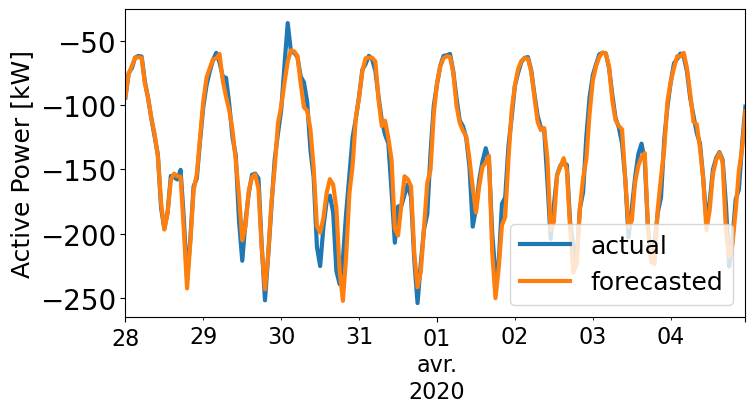

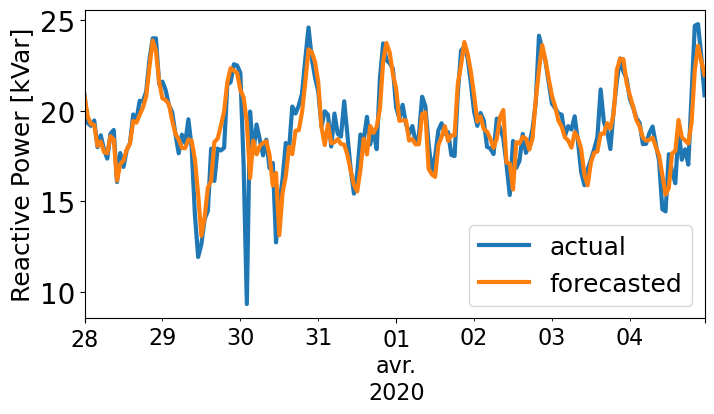

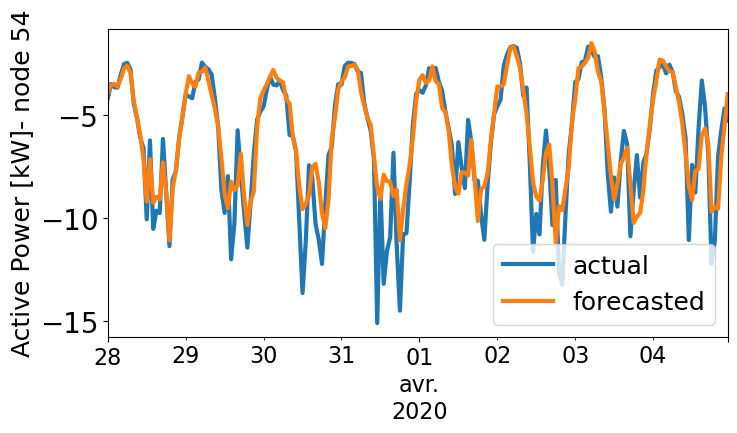

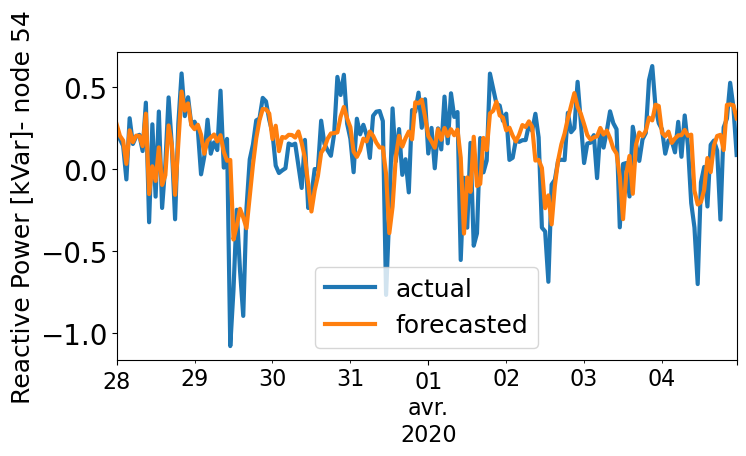

In [17]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('default')
plt.rcParams['figure.figsize']=(8,4)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=20) 

fig, ax1 = plt.subplots(1, 1)
DF_P[test_date:]['tot'].plot(ax=ax1, linewidth=3)
df = pd.DataFrame()
df['tot'] = DF_P[test_date:]['tot']
df['pred'] = list(Model.loc['tot', 'RF_P_exg_complet'])
df['pred'].plot(ax=ax1, linewidth=3)
ax1.legend(['actual', 'forecasted'],fontsize=18)
ax1.set_xlabel('')
ax1.set_ylabel('Active Power [kW]',fontsize=18)
fig.savefig(Fig_address_save + 'ActiveTotal.png', bbox_inches='tight')

fig, ax2 = plt.subplots(1, 1)
DF_Q[test_date:]['tot'].plot(ax=ax2, linewidth=3)
df = pd.DataFrame()
df['tot'] = DF_Q[test_date:]['tot']
df['pred'] = list(Model.loc['tot', 'RF_Q_exg_complet'])
df['pred'].plot(ax=ax2, linewidth=3)
ax2.legend(['actual', 'forecasted'],fontsize=18)
ax2.set_xlabel('')
ax2.set_ylabel('Reactive Power [kVar]',fontsize=18)
fig.savefig(Fig_address_save + 'ReactiveTotal.png', bbox_inches='tight')


node = '54'
fig, ax3 = plt.subplots(1, 1)
DF_P[test_date:][node].plot(ax=ax3, linewidth=3)
df = pd.DataFrame()
df[node] = DF_P[test_date:][node]
df['pred'] = list(Model.loc[node, 'RF_P_exg_complet'])
df['pred'].plot(ax=ax3, linewidth=3)
ax3.legend(['actual', 'forecasted'],fontsize=18)
ax3.set_xlabel('')
ax3.set_ylabel('Active Power [kW]- node ' + node,fontsize=18);

fig, ax4 = plt.subplots(1, 1)
DF_Q[test_date:][node].plot(ax=ax4, linewidth=3)
df = pd.DataFrame()
df[node] = DF_Q[test_date:][node]
df['pred'] = list(Model.loc[node, 'RF_Q_exg_complet'])
df['pred'].plot(ax=ax4, linewidth=3)
ax4.legend(['actual', 'forecasted'],fontsize=18)
ax4.set_xlabel('')
ax4.set_ylabel('Reactive Power [kVar]- node ' + node,fontsize=18);


# Output - Box plots

<Figure size 1200x400 with 0 Axes>

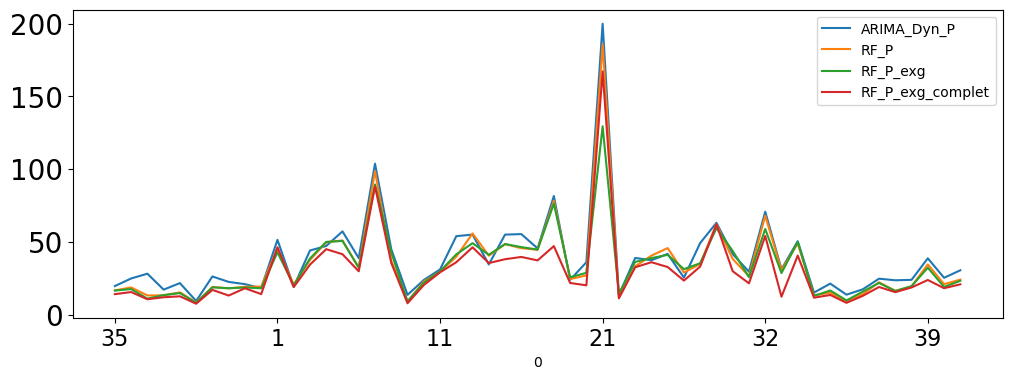

<Figure size 1200x400 with 0 Axes>

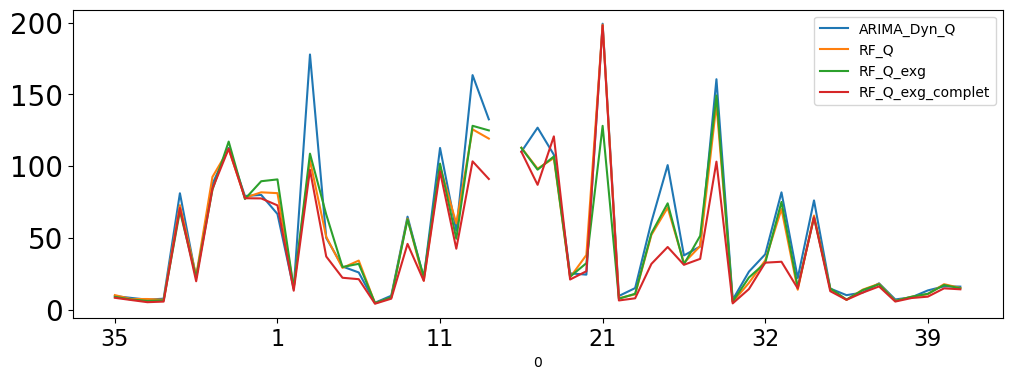

<Figure size 1200x400 with 0 Axes>

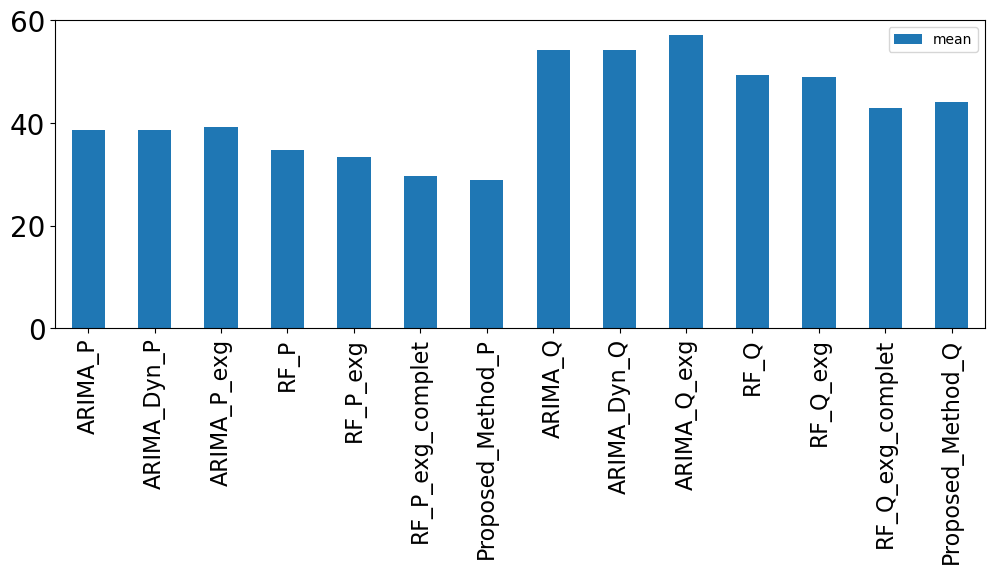

<Figure size 1200x400 with 0 Axes>

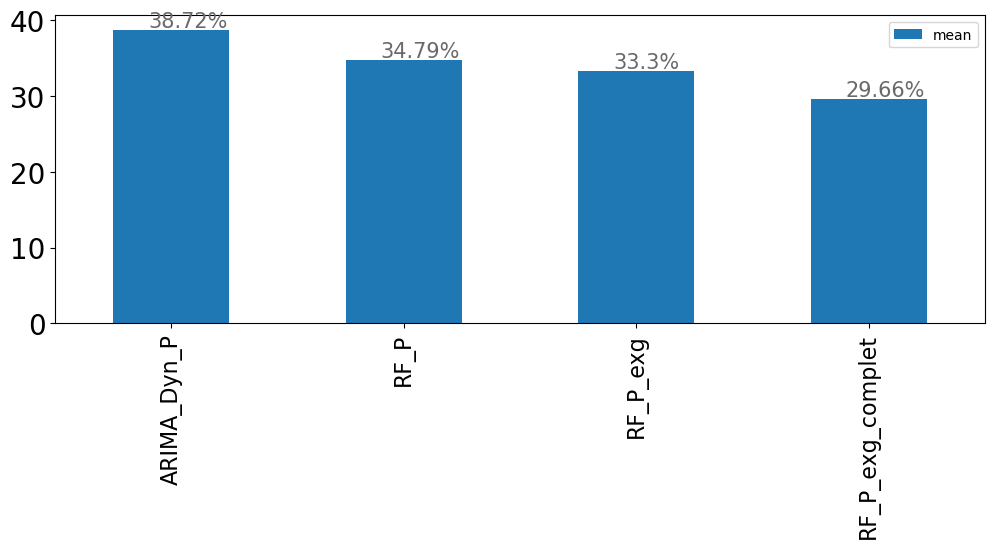

<Figure size 1200x400 with 0 Axes>

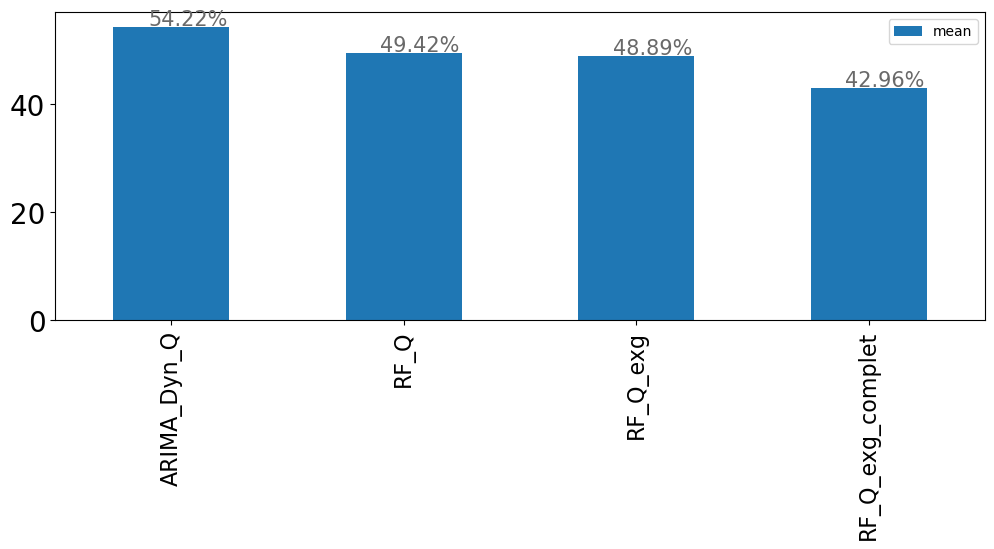

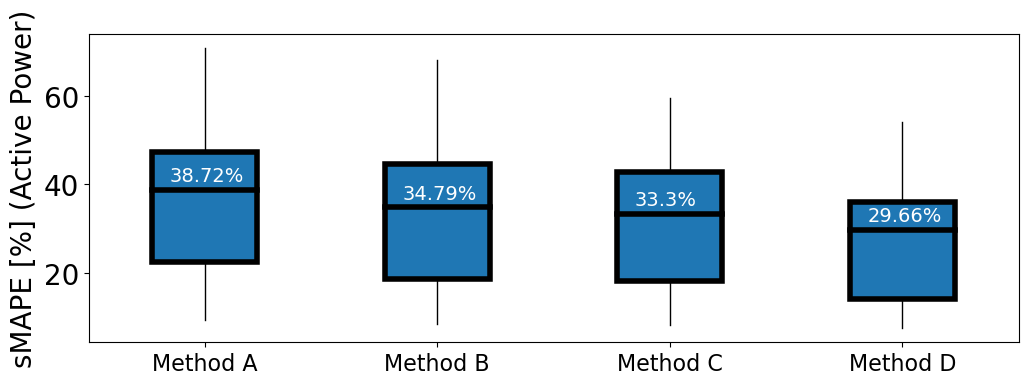

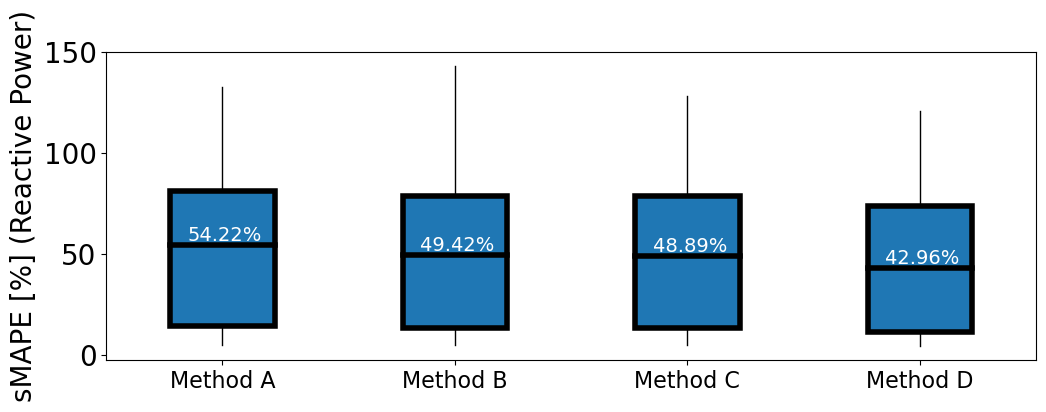

In [24]:
dataframe = sMAPE.loc[Valid_SMs[:-1], ['ARIMA_P', 'ARIMA_Dyn_P', 'ARIMA_P_exg', 'RF_P', 'RF_P_exg','RF_P_exg_complet','ARIMA_Q', 'ARIMA_Dyn_Q', 'ARIMA_Q_exg', 'RF_Q', 'RF_Q_exg','RF_Q_exg_complet']]
dataframe['Proposed_Method_P'] = dataframe[['ARIMA_Dyn_P', 'ARIMA_P_exg', 'RF_P', 'RF_P_exg','RF_P_exg_complet']].min(1)
dataframe['Proposed_Method_Q'] = dataframe[['ARIMA_Dyn_Q', 'ARIMA_Q_exg', 'RF_Q', 'RF_Q_exg','RF_Q_exg_complet']].min(1)

dataframe = dataframe * 100

plt.style.use('default')
plt.rcParams['figure.figsize']=(12,4)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=20) 

# output = pd.DataFrame()
# output['mean'] = dataframe[['ARIMA_P', 'ARIMA_Dyn_P', 'ARIMA_P_exg', 'RF_P', 'RF_P_exg','RF_P_exg_complet', 'Proposed_Method_P', 'ARIMA_Q', 'ARIMA_Dyn_Q', 'ARIMA_Q_exg', 'RF_Q', 'RF_Q_exg','RF_Q_exg_complet', 'Proposed_Method_Q']].mean(axis=0)
plt.figure()
ax1 = dataframe[['ARIMA_Dyn_P', 'RF_P', 'RF_P_exg','RF_P_exg_complet']].plot()

plt.figure()
ax1 = dataframe[['ARIMA_Dyn_Q', 'RF_Q', 'RF_Q_exg','RF_Q_exg_complet']].plot()


output = pd.DataFrame()
output['mean'] = dataframe[['ARIMA_P', 'ARIMA_Dyn_P', 'ARIMA_P_exg', 'RF_P', 'RF_P_exg','RF_P_exg_complet', 'Proposed_Method_P', 'ARIMA_Q', 'ARIMA_Dyn_Q', 'ARIMA_Q_exg', 'RF_Q', 'RF_Q_exg','RF_Q_exg_complet', 'Proposed_Method_Q']].mean(axis=0)
plt.figure()
ax1 = output.plot.bar()

output = pd.DataFrame()
output['mean'] = dataframe[['ARIMA_Dyn_P', 'RF_P', 'RF_P_exg','RF_P_exg_complet']].mean(axis=0)
plt.figure()
ax1 = output.plot.bar()
for i in ax1.patches:
    ax1.text(i.get_x()+.15, i.get_height()+.3, str(round(i.get_height(),2))+'%', fontsize=15, color='dimgrey')


output = pd.DataFrame()
output['mean'] = dataframe[['ARIMA_Dyn_Q', 'RF_Q', 'RF_Q_exg','RF_Q_exg_complet']].mean(axis=0)
plt.figure()
ax2 = output.plot.bar()
for i in ax2.patches:
    ax2.text(i.get_x()+.15, i.get_height()+.3, str(round(i.get_height(),2))+'%', fontsize=15, color='dimgrey')
    

fig, ax = plt.subplots(1, 1)
meanprops = dict(linestyle='-', linewidth=4, color='k')
boxprops = dict(linestyle='-', linewidth=4, color='k')
medianprops = dict(linestyle='-', linewidth=0, color='k')
whiskerprops = dict(linestyle='-', linewidth=1, color='k')
dataframe[['ARIMA_Dyn_P', 'RF_P', 'RF_P_exg','RF_P_exg_complet']].plot.box(ax=ax, whis=1, showmeans=True, meanline=True, patch_artist = True, 
                                                                                          showcaps = False, whiskerprops = whiskerprops,
                                                                                         showfliers=False, boxprops=boxprops, autorange = True,
                                                                                         medianprops=medianprops, meanprops=meanprops, rot=0)

plt.xticks([1, 2, 3, 4], ['Method A', 'Method B', 'Method C', 'Method D'])
ax.set_ylabel('sMAPE [%] (Active Power)', fontsize=20)
for i in ax1.patches:
    ax.text(i.get_x()+1.1, i.get_height()+2, str(round(i.get_height(),2))+'%', fontsize=14, color='white')

plt.show()
fig.savefig(Fig_address_save + 'sMAPE_P.png', bbox_inches='tight')


fig, ax = plt.subplots(1, 1)
meanprops = dict(linestyle='-', linewidth=4, color='k')
boxprops = dict(linestyle='-', linewidth=4, color='k')
medianprops = dict(linestyle='-', linewidth=0, color='k')
whiskerprops = dict(linestyle='-', linewidth=1, color='k')
dataframe[['ARIMA_Dyn_Q', 'RF_Q', 'RF_Q_exg','RF_Q_exg_complet']].plot.box(ax=ax, whis=1, showmeans=True, meanline=True, patch_artist = True, 
                                                                                          showcaps = False, whiskerprops = whiskerprops,
                                                                                         showfliers=False, boxprops=boxprops, autorange = True,
                                                                                         medianprops=medianprops, meanprops=meanprops, rot=0)

plt.xticks([1, 2, 3, 4], ['Method A', 'Method B', 'Method C', 'Method D'])
ax.set_ylabel('sMAPE [%] (Reactive Power)', fontsize=20)
for i in ax2.patches:
    ax.text(i.get_x()+1.1, i.get_height()+2, str(round(i.get_height(),2))+'%', fontsize=14, color='white')

plt.show()
fig.savefig(Fig_address_save + 'sMAPE_Q.png', bbox_inches='tight')


# Output - Data for Matlab

In [19]:
test = pd.DataFrame()
test['Time'] = DF_P[test_date:].index
test = test.set_index('Time')
for v_SM in Valid_SMs:
    test['x' + v_SM + '_pr'] = DF_P[test_date:][v_SM]
    test['x' + v_SM + '_pf1'] = Model.loc[v_SM, 'ARIMA_Dyn_P']
    test['x' + v_SM + '_pf2'] = Model.loc[v_SM, 'RF_P']
    test['x' + v_SM + '_pf3'] = Model.loc[v_SM, 'RF_P_exg']
    test['x' + v_SM + '_pf4'] = Model.loc[v_SM, 'RF_P_exg_complet']
    test['x' + v_SM + '_qr'] = DF_Q[test_date:][v_SM]
    test['x' + v_SM + '_qf1'] = Model.loc[v_SM, 'ARIMA_Dyn_Q']
    test['x' + v_SM + '_qf2'] = Model.loc[v_SM, 'RF_Q']
    test['x' + v_SM + '_qf3'] = Model.loc[v_SM, 'RF_Q_exg']
    test['x' + v_SM + '_qf4'] = Model.loc[v_SM, 'RF_Q_exg_complet']

for v_GE in Valid_GEs_SE:
    test['xg' + v_GE + '_p'] = DF_GE_P[test_date:][v_GE]
    test['xg' + v_GE + '_q'] = DF_GE_Q[test_date:][v_GE]
    test['xg' + v_GE + '_v'] = DF_GE_V[test_date:][v_GE]
    
if (ARIMA_Model == 'learn') or (ARIMA_Model_exg == 'learn') or (ARIMA_Model_exg == 'learn') or (RF_Model == 'learn') or (RF_Model_exg == 'learn') or (RF_Model_exg_complet == 'learn'):
    test.to_csv (csv_address_save, index = False, header=True)
else:
    test.to_csv (csv_address_load, index = False, header=True)
test

x35_pr   x35_pf1   x35_pf2   x35_pf3   x35_pf4  x35_qr  \
Time                                                                          
2020-03-28 00:00:00  -3.014 -3.202187 -3.170563 -3.260780 -3.033359   1.481   
2020-03-28 01:00:00  -2.209 -2.814280 -2.488321 -2.609949 -2.403643   1.591   
2020-03-28 02:00:00  -2.475 -2.547713 -2.549985 -2.624955 -2.371961   1.582   
2020-03-28 03:00:00  -2.229 -2.381316 -2.215992 -2.360124 -2.262650   1.600   
2020-03-28 04:00:00  -1.959 -2.311783 -2.047166 -2.071899 -1.994280   1.695   
...                     ...       ...       ...       ...       ...     ...   
2020-04-04 19:00:00  -6.896 -8.365827 -6.739124 -7.606498 -6.912218   1.716   
2020-04-04 20:00:00  -5.117 -7.442711 -5.980201 -7.082854 -6.205603   1.891   
2020-04-04 21:00:00  -6.281 -6.267141 -5.032698 -5.632582 -5.060511   1.685   
2020-04-04 22:00:00  -5.314 -5.371603 -4.527400 -5.190557 -4.707443   1.905   
2020-04-04 23:00:00  -3.546 -4.334636 -2.989161 -4.190388 -3.888726   1.577   

                      x35_qf1   x35_qf2   x35_qf3   x35_qf4  ...   xtot_qf4  \
Time                                                         ...              
2020-03-28 00:00:00  1.590349  1.517022  1.555542  1.532478  ...  20.784706   
2020-03-28 01:00:00  1.581262  1.592862  1.583575  1.542925  ...  19.666997   
2020-03-28 02:00:00  1.539183  1.563570  1.574887  1.566879  ...  19.252465   
2020-03-28 03:00:00  1.540605  1.610888  1.596161  1.600720  ...  19.207057   
2020-03-28 04:00:00  1.549222  1.652617  1.644689  1.629993  ...  18.045909   
...                       ...       ...       ...       ...  ...        ...   
2020-04-04 19:00:00  1.751554  1.534657  1.738604  1.749491  ...  19.327665   
2020-04-04 20:00:00  1.763489  1.462406  1.688957  1.625174  ...  22.232408   
2020-04-04 21:00:00  1.752727  1.402742  1.710192  1.761328  ...  23.579437   
2020-04-04 22:00:00  1.744294  1.523010  1.717960  1.574687  ...  22.731448   
2020-04-04 23:00:00  1.684856  1.522631  1.625334  1.651717  ...  21.969687   

                         xg1_p     xg1_q     xg1_v      xg5_p     xg5_q  \
Time                                                                      
2020-03-28 00:00:00  18.075667 -7.818000  1.018762  14.042500 -4.902833   
2020-03-28 01:00:00  16.707500 -7.874833  1.024710  12.210000 -4.919500   
2020-03-28 02:00:00  14.270833 -7.703000  1.020305  13.598667 -4.933167   
2020-03-28 03:00:00  12.779667 -7.446000  1.011300  11.004500 -4.926833   
2020-03-28 04:00:00  12.797000 -7.489167  1.007516  10.525667 -5.047000   
...                        ...       ...       ...        ...       ...   
2020-04-04 19:00:00  52.291833 -7.759500  1.007635  21.373000 -4.427667   
2020-04-04 20:00:00  49.099333 -8.960833  1.007451  17.337000 -5.239833   
2020-04-04 21:00:00  42.167833 -8.562167  1.019449  16.996833 -5.583167   
2020-04-04 22:00:00  30.849500 -8.681167  1.022149  20.219000 -5.823667   
2020-04-04 23:00:00  24.524667 -8.498000  1.017339  21.867333 -5.566167   

                        xg5_v      xg9_p      xg9_q     xg9_v  
Time                                                           
2020-03-28 00:00:00  1.019302 -21.896167 -23.057833  1.019424  
2020-03-28 01:00:00  1.025258 -18.968333 -17.858667  1.025380  
2020-03-28 02:00:00  1.020857 -17.059167 -15.212500  1.020975  
2020-03-28 03:00:00  1.011856 -15.500167 -13.346000  1.011971  
2020-03-28 04:00:00  1.008079 -14.018333 -11.354000  1.008194  
...                       ...        ...        ...       ...  
2020-04-04 19:00:00  1.008071 -38.567500 -59.218333  1.008196  
2020-04-04 20:00:00  1.007867 -39.838000 -58.357000  1.007991  
2020-04-04 21:00:00  1.019858 -38.745500 -52.545833  1.019979  
2020-04-04 22:00:00  1.022555 -31.668667 -39.744833  1.022674  
2020-04-04 23:00:00  1.017745 -28.478000 -34.357333  1.017861  

[192 rows x 549 columns]

# Running Matlab code from Python

In [20]:
if (ARIMA_Model == 'learn') or (ARIMA_Model_exg == 'learn') or (ARIMA_Model_exg == 'learn') or (RF_Model == 'learn') or (RF_Model_exg == 'learn') or (RF_Model_exg_complet == 'learn'):
    csv_address = csv_address_save
else:
    csv_address = csv_address_load
eng = matlab.engine.start_matlab()
eng.workspace['csv_address'] = csv_address
eng.workspace['SE_address_save'] = SE_address_save
eng.workspace['grid_address'] = grid_address
eng.workspace['Valid_GEs_SE'] = Valid_GEs_SE
eng.workspace['GE_in_SE'] = GE_in_SE
eng.workspace['Fig_address'] = Fig_address_save


eng.cd(r'.\Functions')
eng.main_SE(nargout=0)

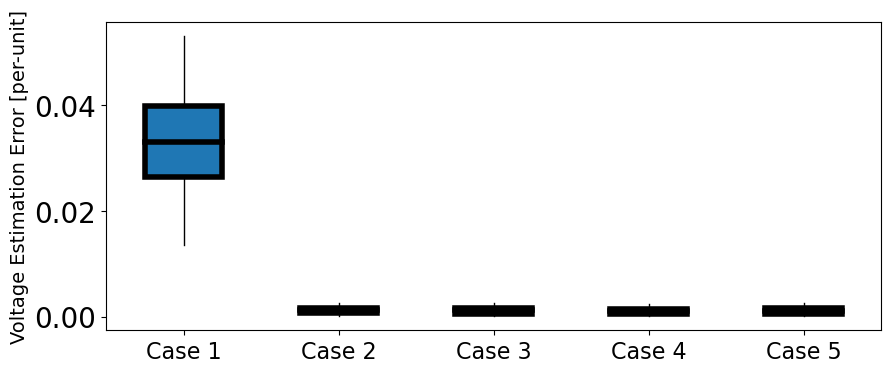

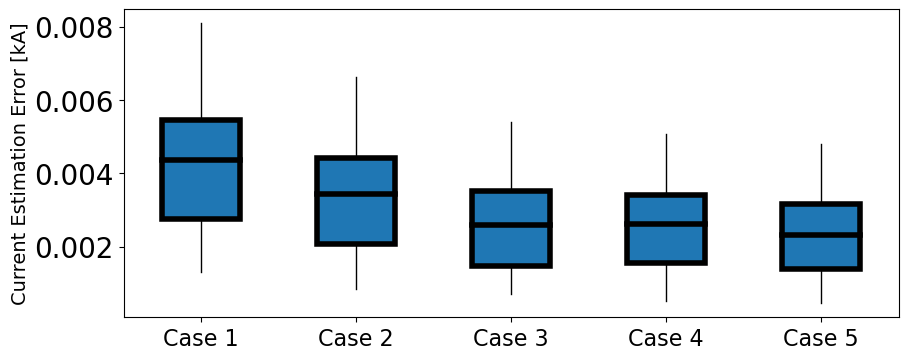

In [25]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

Input = sio.loadmat(SE_address_save)
ErrV1 = Input['ErrV1']
ErrV2 = Input['ErrV2']
ErrV3 = Input['ErrV3']
ErrV4 = Input['ErrV4']
ErrV5 = Input['ErrV5']
ErrI1 = Input['ErrI1']
ErrI2 = Input['ErrI2']
ErrI3 = Input['ErrI3']
ErrI4 = Input['ErrI4']
ErrI5 = Input['ErrI5']

Nb = np.size(ErrV1,0)

Input = sio.loadmat(grid_address)
Sb = Input['Sb'][0][0] / 1000
Vb = 400

Dates = DF_P[test_date:].index#pd.date_range(start=test_date,end=test_date+ timedelta(days = TEST_DAY + 1), freq=DpH_str)#'1h') #"2020-04-04 23:00"

ErrV = pd.DataFrame()
ErrI = pd.DataFrame()
ErrV['Time'] = Dates
ErrI['Time'] = Dates
for i in range(Nb):
    ErrV[str(i+1)+'_1'] = ErrV1[i]
    ErrI[str(i+1)+'_1'] = ErrI1[i] * Sb / Vb
    
for i in range(Nb):
    ErrV[str(i+1)+'_2'] = ErrV2[i]
    ErrI[str(i+1)+'_2'] = ErrI2[i] * Sb / Vb

for i in range(Nb):
    ErrV[str(i+1)+'_3'] = ErrV3[i]
    ErrI[str(i+1)+'_3'] = ErrI3[i] * Sb / Vb

for i in range(Nb):
    ErrV[str(i+1)+'_4'] = ErrV4[i]
    ErrI[str(i+1)+'_4'] = ErrI4[i] * Sb / Vb

for i in range(Nb):
    ErrV[str(i+1)+'_5'] = ErrV5[i]
    ErrI[str(i+1)+'_5'] = ErrI5[i] * Sb / Vb
    
ErrV = ErrV.sort_values('Time')
ErrV = ErrV.set_index('Time')

ErrI = ErrI.sort_values('Time')
ErrI = ErrI.set_index('Time')

ErrV['max1'] = ErrV.iloc[:,0:Nb].mean(axis=1)
ErrV['max2'] = ErrV.iloc[:,Nb:Nb*2].mean(axis=1)
ErrV['max3'] = ErrV.iloc[:,Nb*2:Nb*3].mean(axis=1)
ErrV['max4'] = ErrV.iloc[:,Nb*3:Nb*4].mean(axis=1)
ErrV['max5'] = ErrV.iloc[:,Nb*4:Nb*5].mean(axis=1)

ErrI['max1'] = ErrI.iloc[:,0:Nb].mean(axis=1)
ErrI['max2'] = ErrI.iloc[:,Nb:Nb*2].mean(axis=1)
ErrI['max3'] = ErrI.iloc[:,Nb*2:Nb*3].mean(axis=1)
ErrI['max4'] = ErrI.iloc[:,Nb*3:Nb*4].mean(axis=1)
ErrI['max5'] = ErrI.iloc[:,Nb*4:Nb*5].mean(axis=1)

import seaborn as sns
plt.style.use('default')
plt.rcParams['figure.figsize']=(10,4)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=20) 


fig, ax1 = plt.subplots(1, 1)
meanprops = dict(linestyle='-', linewidth=4, color='k')
boxprops = dict(linestyle='-', linewidth=4, color='k')
medianprops = dict(linestyle='-', linewidth=0, color='k')
whiskerprops = dict(linestyle='-', linewidth=1, color='k')
ErrV[['max1', 'max2', 'max4', 'max3', 'max5']].plot.box(ax=ax1, whis=1, showmeans=True, meanline=True, patch_artist = True, 
                                                                                          showcaps = False, whiskerprops = whiskerprops,
                                                                                         showfliers=False, boxprops=boxprops, autorange = True,
                                                                                         medianprops=medianprops, meanprops=meanprops, rot=0)

plt.xticks([1, 2, 3, 4, 5], ['Case 1', 'Case 2', 'Case 3', 'Case 4', 'Case 5'])
ax1.set_ylabel('Voltage Estimation Error [per-unit]', fontsize=14)
plt.show()
fig.savefig(Fig_address_save + 'ErrV.png', bbox_inches='tight')


fig, ax1 = plt.subplots(1, 1)
meanprops = dict(linestyle='-', linewidth=4, color='k')
boxprops = dict(linestyle='-', linewidth=4, color='k')
medianprops = dict(linestyle='-', linewidth=0, color='k')
whiskerprops = dict(linestyle='-', linewidth=1, color='k')
ErrI[['max1', 'max2', 'max4', 'max3', 'max5']].plot.box(ax=ax1, whis=1, showmeans=True, meanline=True, patch_artist = True, 
                                                                                          showcaps = False, whiskerprops = whiskerprops,
                                                                                         showfliers=False, boxprops=boxprops, autorange = True,
                                                                                         medianprops=medianprops, meanprops=meanprops, rot=0)

plt.xticks([1, 2, 3, 4, 5], ['Case 1', 'Case 2', 'Case 3', 'Case 4', 'Case 5'])
ax1.set_ylabel('Current Estimation Error [kA]', fontsize=14)
plt.show()
fig.savefig(Fig_address_save + 'ErrI.png', bbox_inches='tight')


# Correlation table of variables

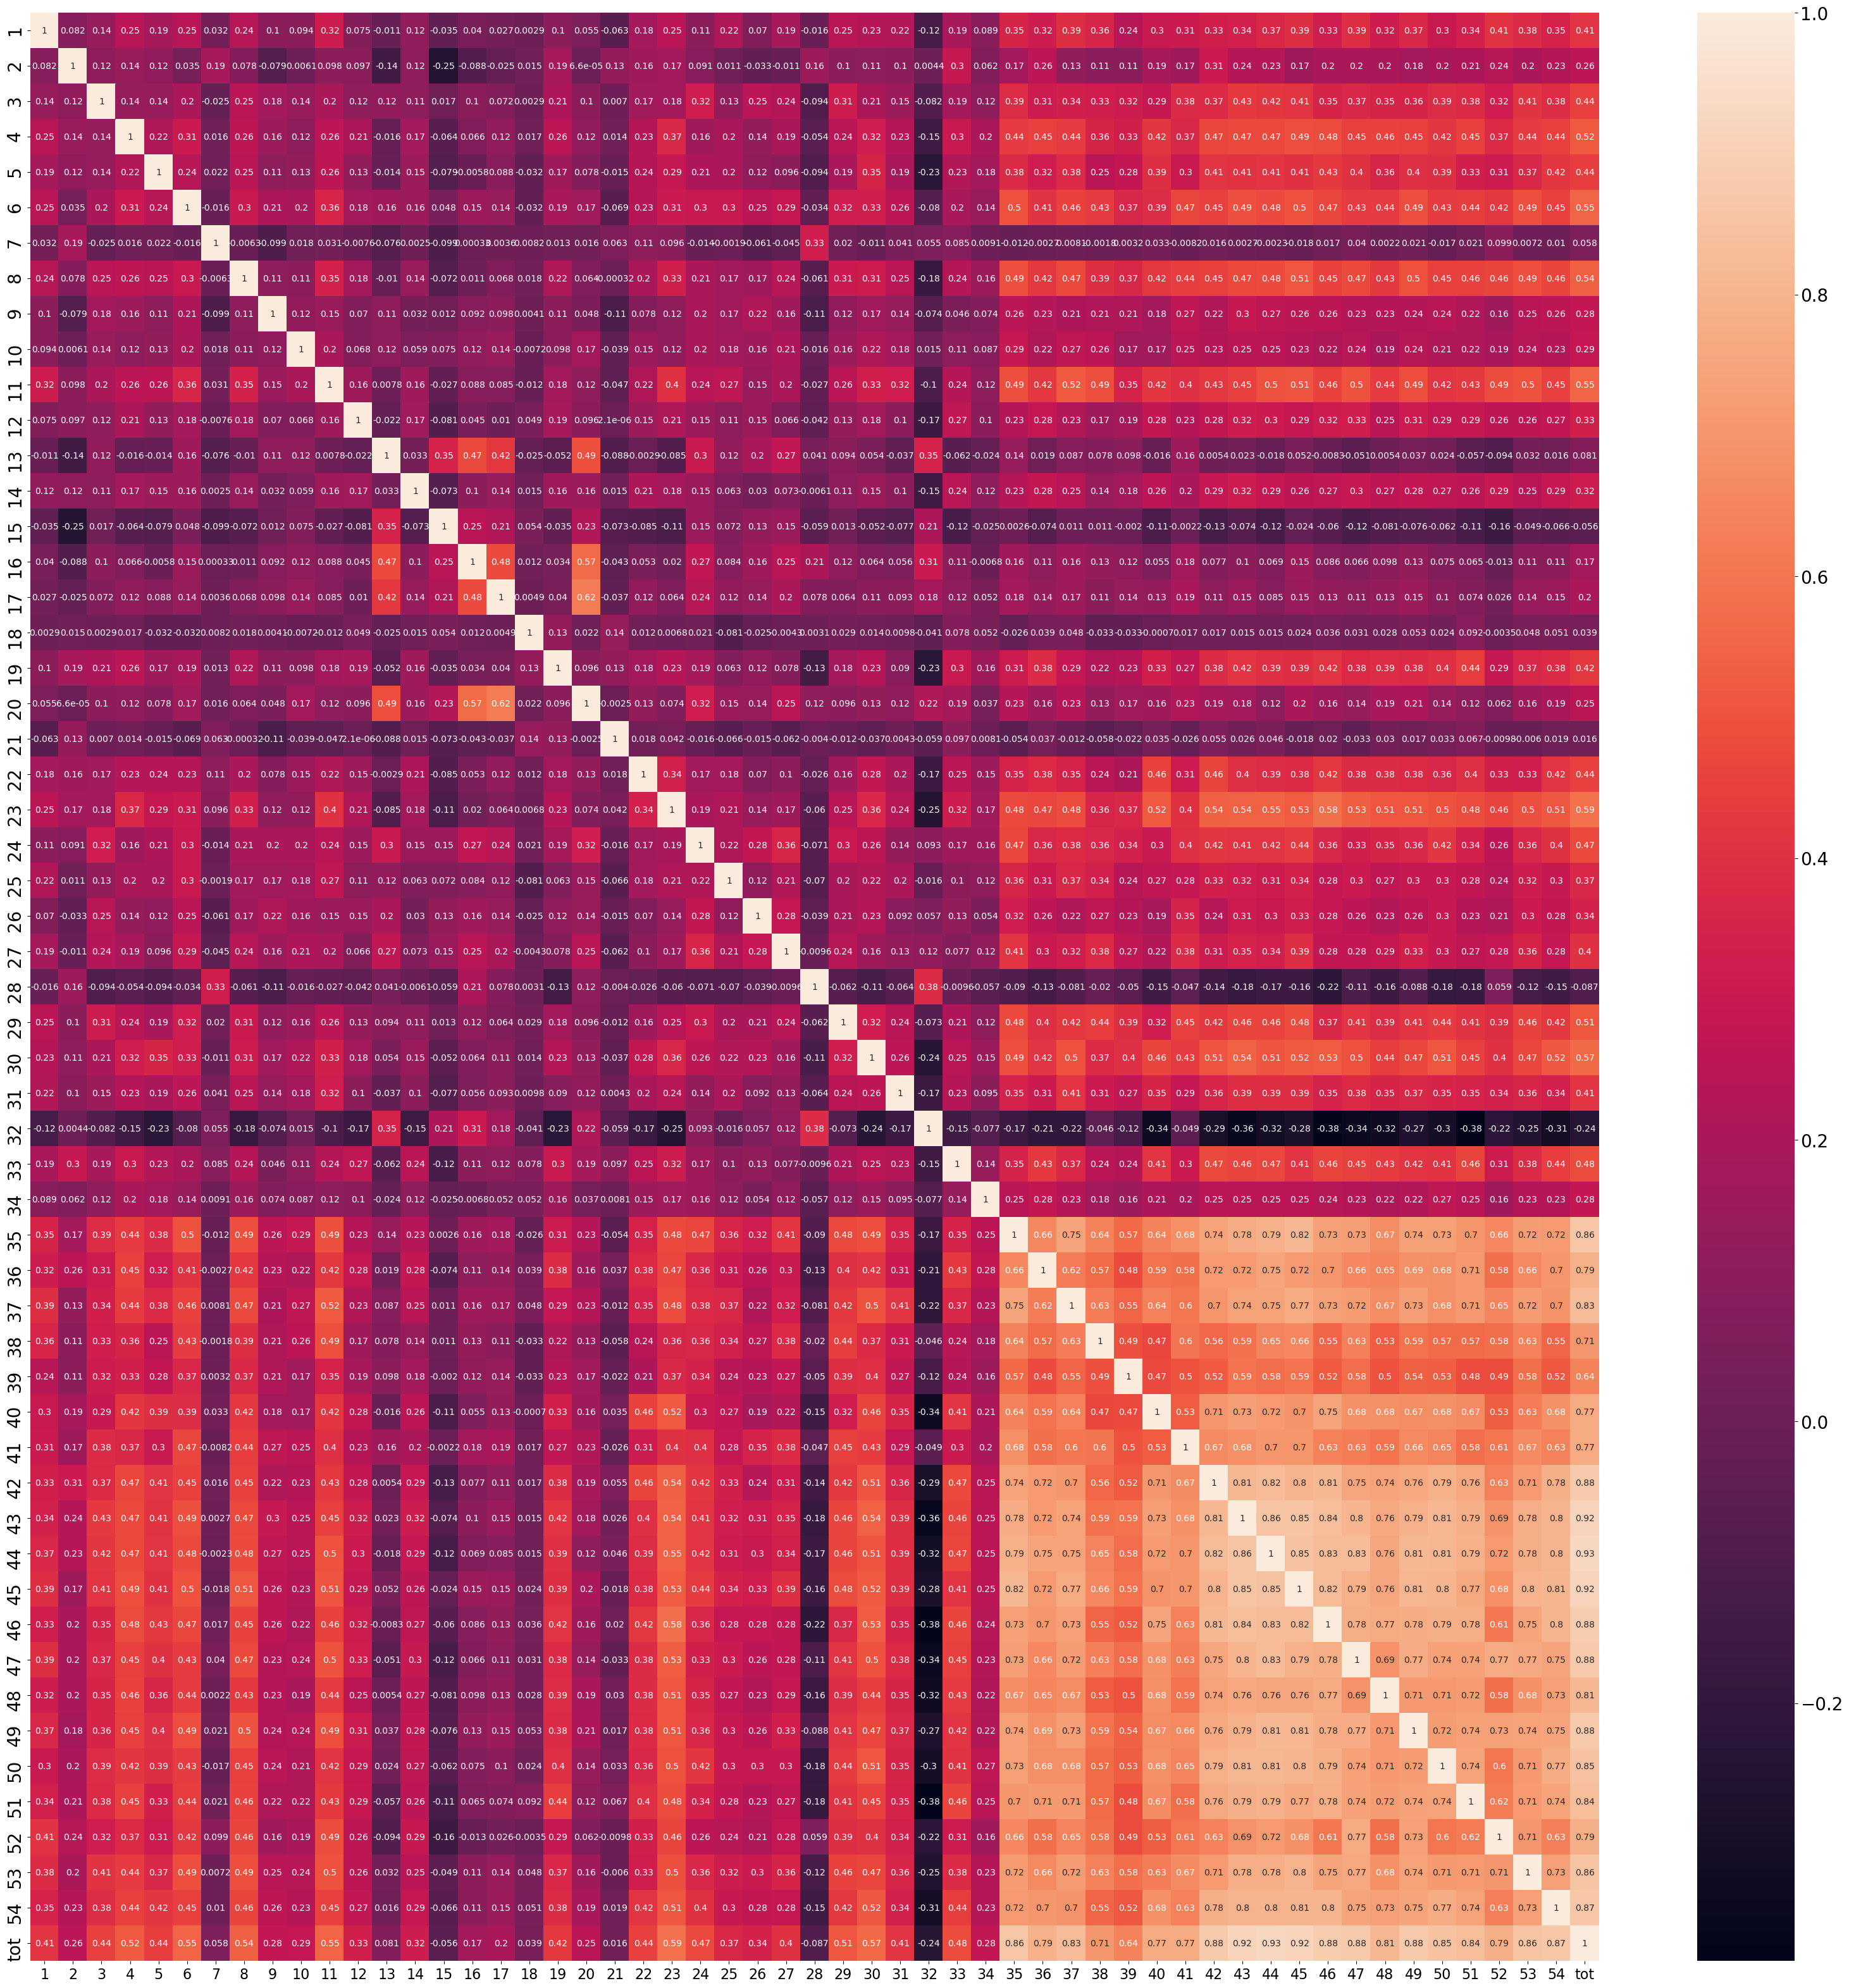

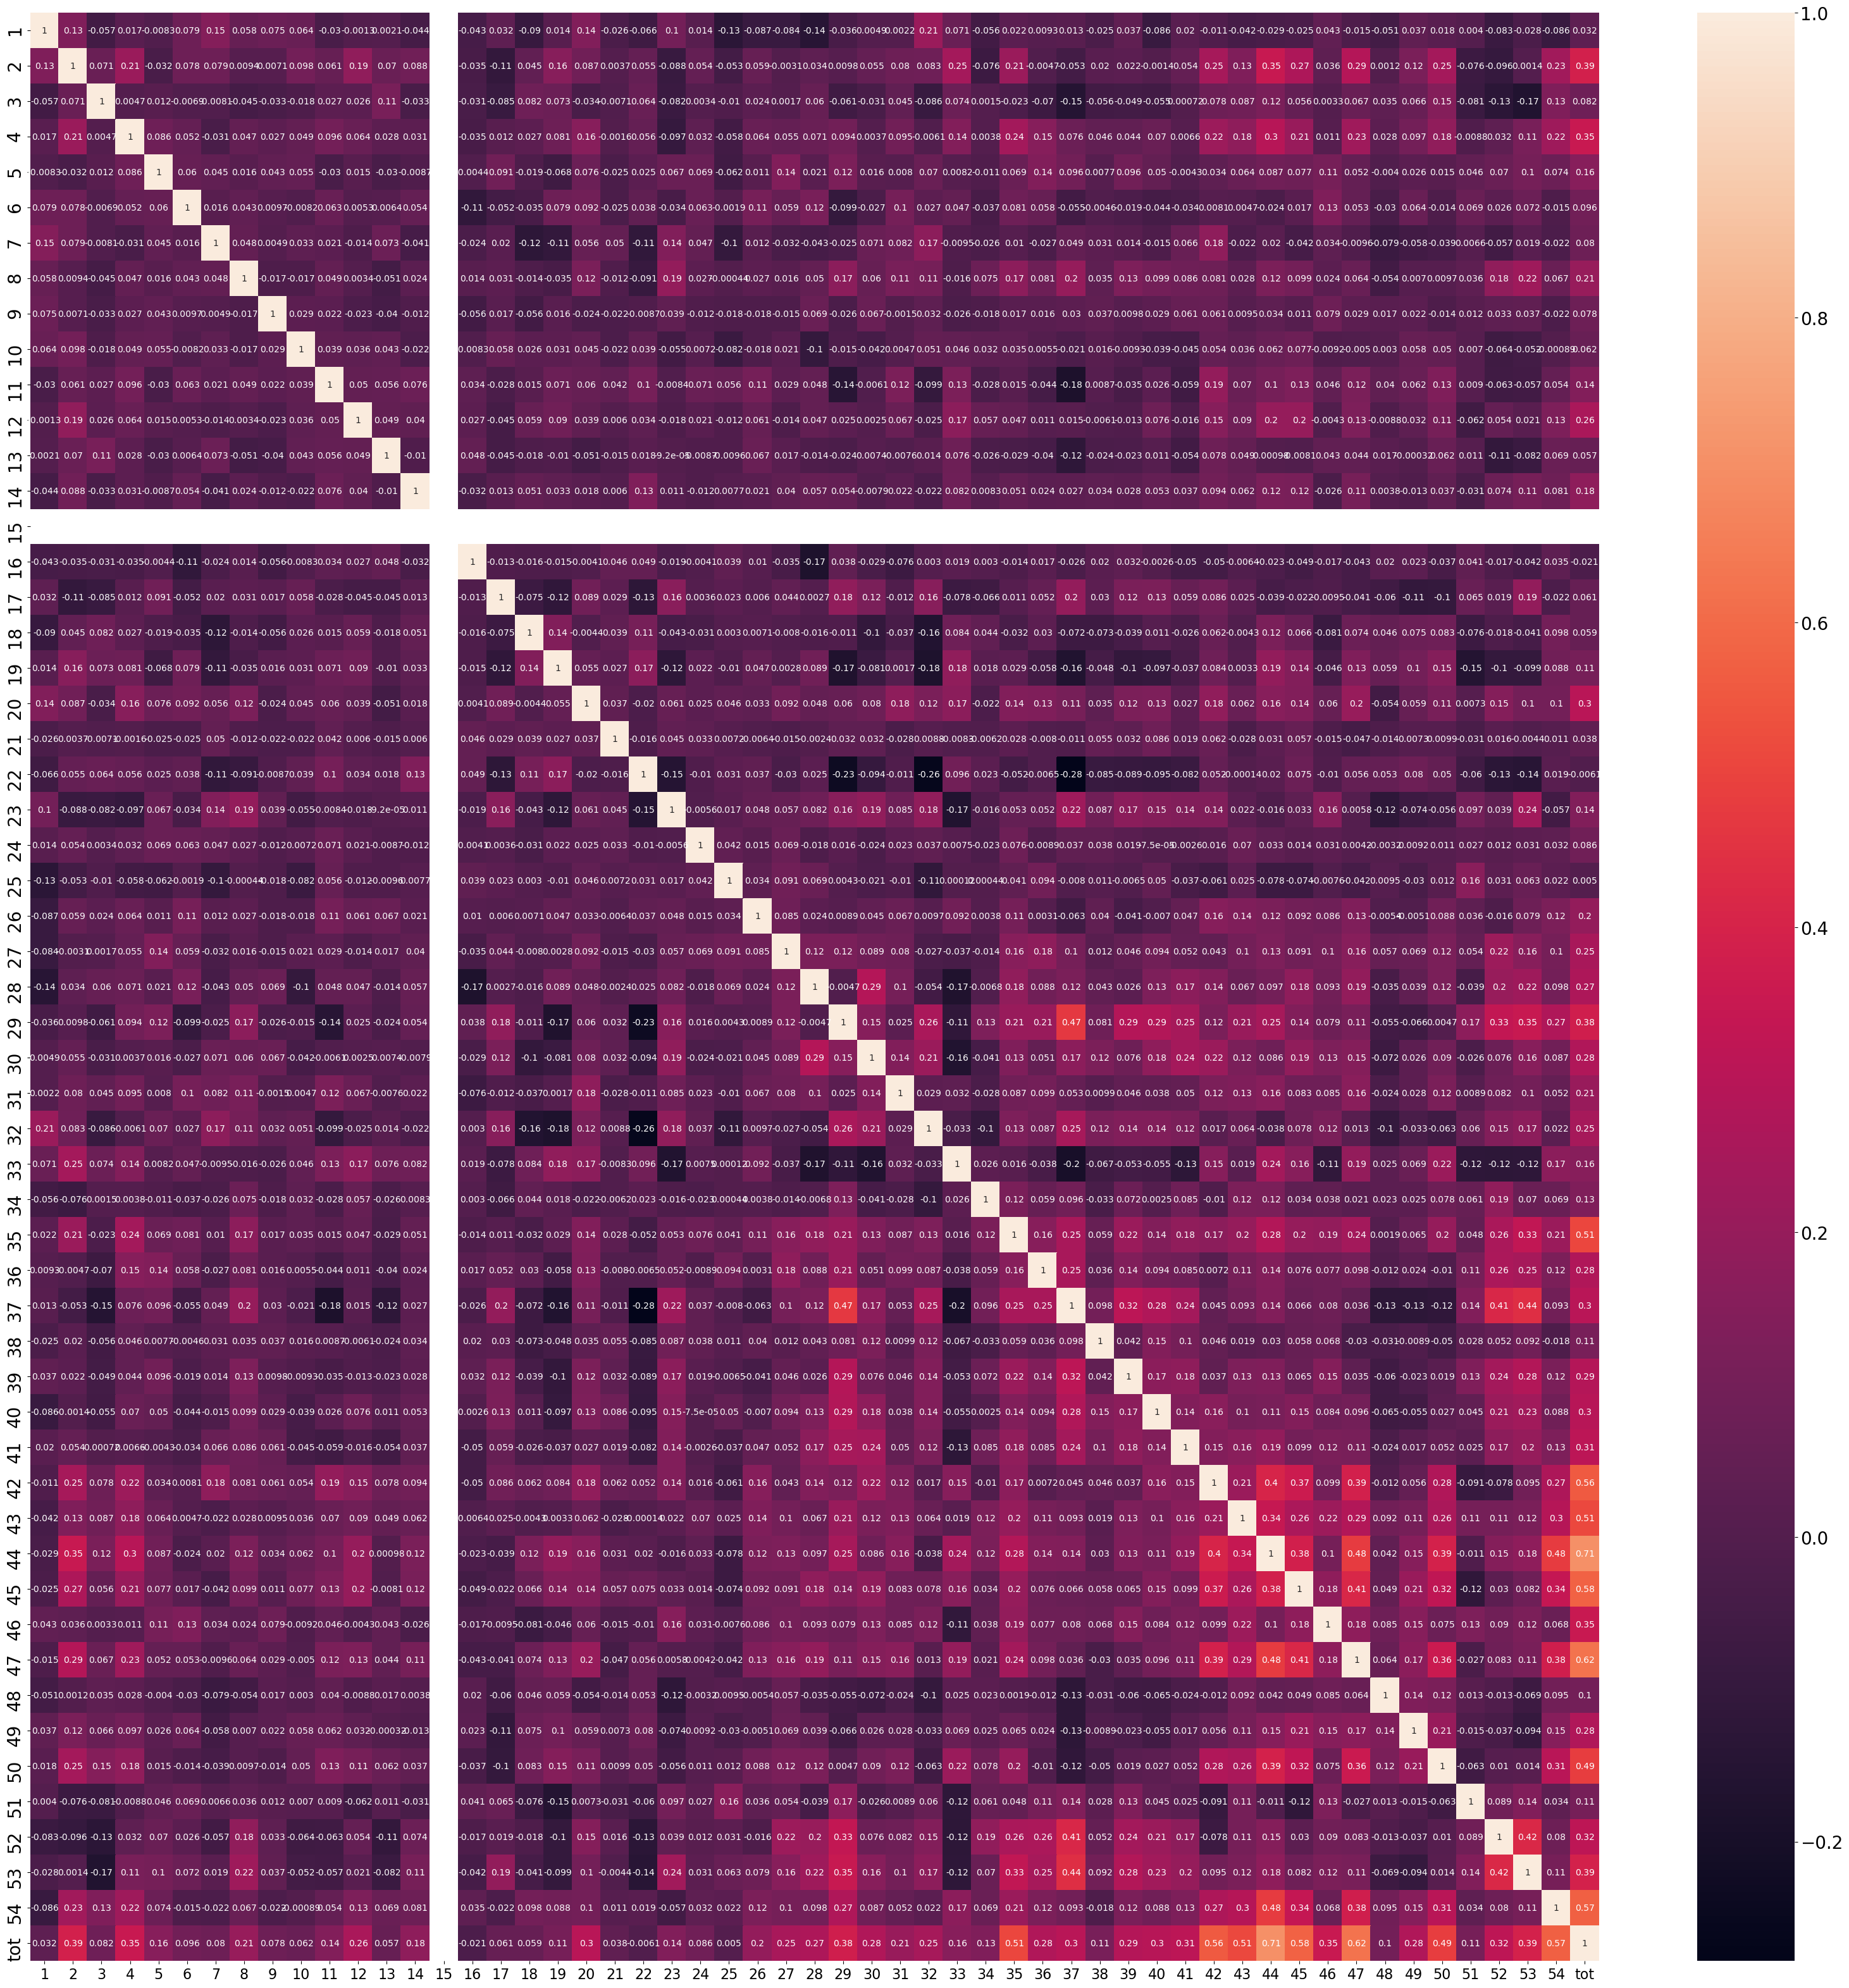

In [22]:
plt.rcParams['figure.figsize']=(40,40)

fig, ax1 = plt.subplots(1, 1)
corrMatrix = DF_P.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()
fig.savefig(Fig_address_save + 'corrMatrix_P.png', bbox_inches='tight')

fig, ax1 = plt.subplots(1, 1)
corrMatrix = DF_Q.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()
fig.savefig(Fig_address_save + 'corrMatrix_Q.png', bbox_inches='tight')